# Analysis with python notebook of all results

Steps:

1. Collect all results of the simulation on a python readable file, having done reblocking before

2. Analyze molecules, QMC versus DFT\
    a. Analysis DMC values, timestep dependence \
    b. Comparison with DFT and CCSD(T) (writes *results_mol_dft.pkl*, which also includes CCSD(T) results)

3. Analyze dimers binding energies \
    a. Do extrapolations w/ w/o Jopt on molecules \
    b. Define gold, silver, bronze schemes, and their cost

4. Compare binding energies with other references 

5. Tool to predict QMC cost \
    a. Multilinear fit of the variance \
    b. Use of Student's t distribution to estimate cost 

6. Plots for some relevant cases

7. Plots for the paper


In [1]:
import os
import re
import math
import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from def_colors import map_DMC, dmc_color, dft_color

from define_setup import *

# Read mol_info
with open( 'mol_info.pkl', 'rb' ) as f:
    mol_info = pickle.load( f )
#mol_info

df_mol_info = pd.read_csv( 'mol_info.csv', index_col=0 )
df_mol_info

# Read results monomer
import pickle
with open( dir_analysis+'results_mol.pkl', 'rb' ) as f:
    results_mol = pickle.load( f )


In [2]:
mol_info['Neopentane']

{'ref': '36_1',
 'test': False,
 'name': 'neopentane',
 'formula': 'C(CH3)4',
 'atoms': {'H': 12, 'C': 5, 'N': 0, 'O': 0},
 'Nel': 42,
 'Nelv': 32}

In [3]:
# Define name and color convenctions

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

def map_DMC( name ):
    if ( name == 'DMC' ):
        rename = 'DMC/LA/ZSGMA'
    elif ( name == 'DMCdla' ):
        rename = 'DMC/DLA/ZSGMA'
    elif ( name == 'DMCdla5' ):
        rename = 'DMC/DLA/ZSGMA*'
    elif ( name == 'DMCtm5' ):
        rename = 'DMC/TM/ZSGMA*'
    else:
        rename = 'DMC(unknown)'
    return rename

def dmc_color( dmc_type, dmc_Jas='Jopt' ):
    if dmc_type=='DMCdla5':
        if dmc_Jas=='Jopt':
            color = 'green'
        elif dmc_Jas=='Jdimer':
            color = 'red'
        else:
            color = 'violet'
    elif dmc_type=='DMCtm5':
        if dmc_Jas=='JoptLA':
            color = 'blue'
        elif dmc_Jas=='Jopt':
            color = 'cyan'
        elif dmc_Jas=='Jdimer':
            color = 'gray'
        else:
            color = 'violet'
    elif dmc_type=='DMCdla':
        if dmc_Jas=='Jopt':
            color = 'gold'
        elif dmc_Jas=='Jdimer':
            color = 'yellow'
        else:
            color = 'violet'
    elif dmc_type=='DMC':
        if dmc_Jas=='Jopt':
            color = 'magenta'
        elif dmc_Jas=='Jdimer':
            color = 'orange'
        else:
            color = 'violet'        
    return color

def dft_color( name ):
    if name == 'LDA':
        c = 'yellow'
    elif name == 'PBE':
        c = 'orange'
    elif name == 'B3LYP':
        c = 'red'
    elif name == 'HF':
        c = 'gray'
    elif name == '0.10':
        c = 'cyan'
    elif name == '0.03':
        c = 'blue'
    elif name == '0.01':
        c = 'green'
    elif name == '0.003':
        c = 'black'
    else:
        c = 'light green'
    return c


In [4]:
# Remove empty data in results_mol

# results_mol[ mol_name ][ mol_id ][ dmc_type ][ dmc_Jas ][ tau ]
# clear from fields without dmc results

list_clean = []

for mol in results_mol:
    #print(mol)
    for mol_id in results_mol[mol]:
        #print(mol_id)
        #for dmc_type in results_mol[mol][mol_id]:
            #print(dmc_type)
        if len(results_mol[mol][mol_id].keys())==0:
            print(mol,mol_id)
            list_clean.append( [mol,mol_id] )

#print(list_clean)
for l in list_clean:
    print(l)
    del results_mol[l[0]][l[1]]

Benzene 24_2
Pyridine 25_2
['Benzene', '24_2']
['Pyridine', '25_2']


In [5]:
results_mol.keys()

dict_keys(['AcNH2', 'AcOH', 'Benzene', 'Cyclopentane', 'Ethene', 'Ethyne', 'MeNH2', 'MeOH', 'Neopentane', 'Pentane', 'Peptide', 'Pyridine', 'Uracil', 'Water'])

In [6]:
# TEST read into results_mol
for mol in mol_names:
    for mol_id in results_mol[mol].keys():
        for dmc_type in results_mol[mol][mol_id].keys():
            for dmc_Jas in results_mol[mol][mol_id][dmc_type].keys():
                data = results_mol[mol][mol_id][dmc_type][dmc_Jas]
                taus = data.keys()
                print( f'{mol} {mol_id} {dmc_type} {dmc_Jas} {len(taus)} tau {taus}' )

AcNH2 21_1 DMCdla5 Jopt 14 tau dict_keys(['0.10', '0.16', '0.05', '0.02', '0.03', '0.04', '0.003', '0.13', '0.25', '0.08', '0.01', '0.2', '0.06', '0.3'])
AcNH2 21_1 DMCdla5 Jdimer 3 tau dict_keys(['0.01', '0.03', '0.10'])
AcNH2 21_2 DMCdla5 Jopt 3 tau dict_keys(['0.10', '0.03', '0.01'])
AcNH2 23_1 DMCdla5 Jopt 4 tau dict_keys(['0.10', '0.03', '0.003', '0.01'])
AcNH2 53_2 DMCdla5 Jopt 3 tau dict_keys(['0.10', '0.03', '0.01'])
AcNH2 53_2 DMCdla5 Jdimer 3 tau dict_keys(['0.01', '0.03', '0.10'])
AcNH2 62_2 DMCdla5 Jopt 4 tau dict_keys(['0.10', '0.03', '0.003', '0.01'])
AcOH 20_1 DMCtm5 JoptLA 8 tau dict_keys(['0.10', '0.006', '0.03', '0.04', '0.02', '0.003', '0.01', '0.06'])
AcOH 20_1 DMCtm5 Jopt 7 tau dict_keys(['0.003', '0.01', '0.06', '0.03', '0.006', '0.02', '0.10'])
AcOH 20_1 DMCdla5 Jopt 14 tau dict_keys(['0.10', '0.16', '0.05', '0.02', '0.03', '0.04', '0.003', '0.13', '0.25', '0.08', '0.01', '0.2', '0.06', '0.3'])
AcOH 20_1 DMCdla5 Jdimer 7 tau dict_keys(['0.06', '0.01', '0.003', '0

In [7]:
# TEST conversion into dataframe
df = pd.DataFrame(results_mol['AcNH2']['21_1']['DMCdla5']['Jopt']).transpose()
newindex = [float(tau) for tau in df.index]
df.index = newindex
df.sort_index(ascending=False, inplace=True)
df
#df[['ene','err']]
df[ df.index < 0.05 ]
#df[ df.index < 0.05 ]['ene']

,ene,err,units,TotTimeSim[au],Pop,Pop-err,Var[au],tau_eff[au],corr-time[au],machine,N_MPI,cost,target_weight
0.040,-25290.159667,0.030095,kcal/mol,1220.0,63974.552628,0.829389,0.591824,0.038443,0.276016,linuxpc-intel-slurm-parallel.peta4-icelake-zen,152,0.379274,64000.0
0.030,-25289.971374,0.031483,kcal/mol,1215.0,63964.995992,0.72106,0.616691,0.029181,0.307369,linuxpc-intel-slurm-parallel.peta4-knl,320,2.068576,64000.0
0.020,-25289.92147,0.035623,kcal/mol,1010.0,63977.9592,0.639359,0.599023,0.019673,0.2961,linuxpc-intel-slurm-parallel.peta4-icelake-zen,152,0.378092,64000.0
0.010,-25289.974516,0.030749,kcal/mol,1005.0,63979.291548,0.451912,0.606618,0.009934,0.256561,linuxpc-intel-slurm-parallel.peta4-knl,320,2.066127,64000.0
0.003,-25290.211134,0.029811,kcal/mol,1201.5,63992.274424,0.226432,0.618657,0.002996,0.284465,linuxpc-intel-slurm-parallel.peta4-icelake,152,0.351324,64000.0


In [8]:
mol_names

('AcNH2',
 'AcOH',
 'Benzene',
 'Cyclopentane',
 'Ethene',
 'Ethyne',
 'MeNH2',
 'MeOH',
 'Neopentane',
 'Pentane',
 'Peptide',
 'Pyridine',
 'Uracil',
 'Water')

In [9]:
# TEST read mol_id
l = list(results_mol['Uracil'].keys())
np.sort( list(results_mol['Uracil'].keys()) )
l.sort()
l

['17_1',
 '17_2',
 '22_2',
 '23_2',
 '26_1',
 '26_2',
 '28_2',
 '29_2',
 '31_1',
 '32_1',
 '41_1',
 '42_1',
 '43_1']

['17_1', '17_2', '22_2', '23_2', '26_1', '26_2', '28_2', '29_2', '31_1', '32_1', '41_1', '42_1', '43_1']
Doing mol_id=17_1, idx=0
Doing mol_id=17_2, idx=1
Doing mol_id=22_2, idx=2
Doing mol_id=23_2, idx=3
Doing mol_id=26_1, idx=4


/var/folders/6n/1hr7hr_s07557tv9vmdpt9c40000gn/T/ipykernel_20893/2740981116.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(labels=['0','','0.01','0.03','0.1'],rotation=90)
/var/folders/6n/1hr7hr_s07557tv9vmdpt9c40000gn/T/ipykernel_20893/2740981116.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(labels=['0','','0.01','0.03','0.1'],rotation=90)
/var/folders/6n/1hr7hr_s07557tv9vmdpt9c40000gn/T/ipykernel_20893/2740981116.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(labels=['0','','0.01','0.03','0.1'],rotation=90)
/var/folders/6n/1hr7hr_s07557tv9vmdpt9c40000gn/T/ipykernel_20893/2740981116.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(labels=['0','','0.01','0.03','0.1'],rotation=90)
/var/folders/6n/1hr7hr_s07557tv9vmdpt9c40000gn/T/ipykernel_20893/274

Doing mol_id=26_2, idx=5
Doing mol_id=28_2, idx=6
Doing mol_id=29_2, idx=7
Doing mol_id=31_1, idx=8
Doing mol_id=32_1, idx=9
Doing mol_id=41_1, idx=10
Doing mol_id=42_1, idx=11
Doing mol_id=43_1, idx=12


min=-48315.9231179452	max=-48308.0453634375


/var/folders/6n/1hr7hr_s07557tv9vmdpt9c40000gn/T/ipykernel_20893/2740981116.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


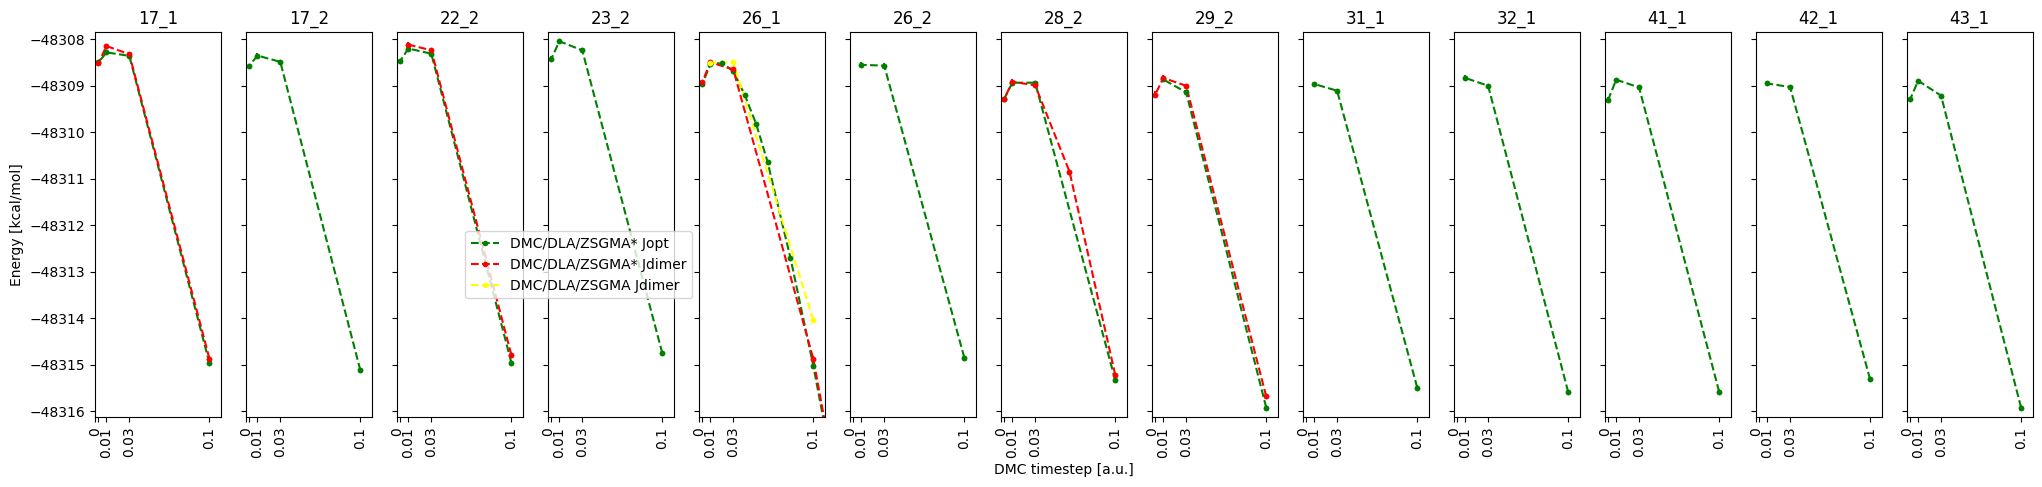

In [10]:
verbose = False

#mol = 'AcNH2'
mol = 'Uracil'
#mol = 'Water'


mol_ids = list( results_mol[mol].keys() )
mol_ids.sort()
print(mol_ids)

nplots = len( mol_ids )
fig, ax = plt.subplots(1,nplots, sharey=True, figsize=(25, 5))

enemin=0.0
enemax=-1e6
#for mol in mol_names[:1]:
for idx, mol_id in enumerate( mol_ids ):
        print( f'Doing mol_id={mol_id}, idx={idx}' )
        ax[idx].set_title(f'{mol_id}')
        ax[idx].set_xlim([0,0.11])

        for dmc_type in results_mol[mol][mol_id].keys():
            for dmc_Jas in results_mol[mol][mol_id][dmc_type].keys():
                data = results_mol[mol][mol_id][dmc_type][dmc_Jas]
                taus = data.keys()
                if verbose: print( f'\n{mol} {mol_id} {dmc_type} {dmc_Jas} {len(taus)} tau {taus}' )
                df = pd.DataFrame( data ).transpose()
                df.index = [float(tau) for tau in df.index]
                df.sort_index(ascending=False, inplace=True)
                #df.astype({'ene':'float'}).dtypes
                if verbose: print( df[['ene','err']] )
                
                ax[idx].set_xlim([0.,0.11])
                ax[idx].set_xticklabels(labels=['0','','0.01','0.03','0.1'],rotation=90)
                ax[idx].set_xticks(ticks=[0,0.003, 0.01, 0.03, 0.1])
                try:
                    taus = np.array( df.index, dtype=np.double )
                    enes = np.array( df['ene'], dtype=np.double )
                    errs = np.array( df['err'], dtype=np.double )
                    c = dmc_color( dmc_type, dmc_Jas )
                    ax[idx].plot( taus, enes, '.--', label=f'{map_DMC(dmc_type)} {dmc_Jas}', color=c )
                    ax[idx].errorbar( taus, enes, errs, color=c, fmt='.' )
                except:
                    pass
                thismin = min(np.array( df[ df.index<0.11 ]['ene'], dtype=np.double ))
                thismax = max(np.array( df[ df.index<0.11 ]['ene'], dtype=np.double ))
                if enemin > thismin: 
                    enemin = thismin
                    if verbose: print(f'\n*** min={enemin}\tmax={enemax} // update min ***')
                if enemax < thismax:
                    enemax = thismax
                    if verbose: print(f'\n*** min={enemin}\tmax={enemax} // update max ***')

#ax[0].set_yticklabels(['{:,.0f}'.format(x) for x in ax[0].get_yticks()])
ax[0].set_ylabel('Energy [kcal/mol]')
ax[int( idx/2 )].set_xlabel('DMC timestep [a.u.]')

print(f'\n\nmin={enemin}\tmax={enemax}')
plt.ylim([enemin-0.2,enemax+0.2])
ax[4].legend(bbox_to_anchor=(0, 0.5))
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()
fig.savefig(f'FIG02a/Multi_{mol}.png',format='png',dpi=300)

['21_1', '21_2', '23_1', '53_2', '62_2']
Doing mol_id=21_1, idx=0
Doing mol_id=21_2, idx=1
Doing mol_id=23_1, idx=2
Doing mol_id=53_2, idx=3
Doing mol_id=62_2, idx=4


min=-25294.3976400425	max=-25289.8404503845


/var/folders/6n/1hr7hr_s07557tv9vmdpt9c40000gn/T/ipykernel_20893/2021861018.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(labels=['0','','0.01','0.03','0.1'],rotation=90)
/var/folders/6n/1hr7hr_s07557tv9vmdpt9c40000gn/T/ipykernel_20893/2021861018.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(labels=['0','','0.01','0.03','0.1'],rotation=90)
/var/folders/6n/1hr7hr_s07557tv9vmdpt9c40000gn/T/ipykernel_20893/2021861018.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(labels=['0','','0.01','0.03','0.1'],rotation=90)
/var/folders/6n/1hr7hr_s07557tv9vmdpt9c40000gn/T/ipykernel_20893/2021861018.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(labels=['0','','0.01','0.03','0.1'],rotation=90)
/var/folders/6n/1hr7hr_s07557tv9vmdpt9c40000gn/T/ipykernel_20893/202

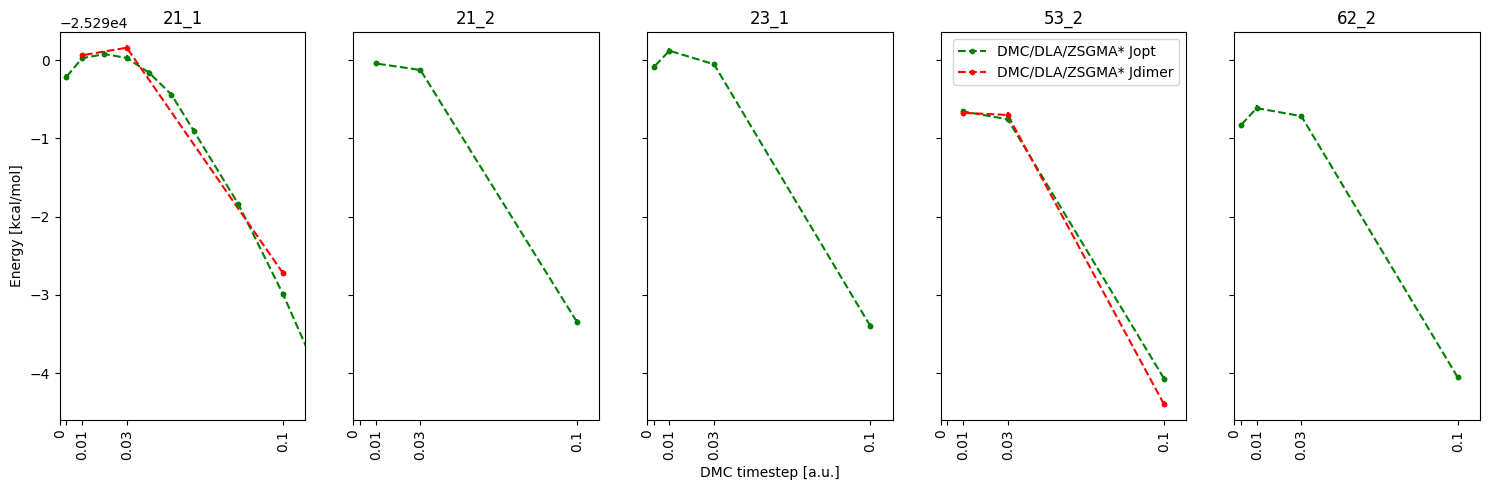

In [11]:
verbose = False

mol = 'AcNH2'
#mol = 'Uracil'
#mol = 'Water'


mol_ids = list( results_mol[mol].keys() )
mol_ids.sort()
print(mol_ids)

nplots = len( mol_ids )
fig, ax = plt.subplots(1,nplots, sharey=True, figsize=(3*nplots, 5))

enemin=0.0
enemax=-1e6
#for mol in mol_names[:1]:
for idx, mol_id in enumerate( mol_ids ):
        print( f'Doing mol_id={mol_id}, idx={idx}' )
        ax[idx].set_title(f'{mol_id}')
        ax[idx].set_xlim([0,0.11])

        for dmc_type in results_mol[mol][mol_id].keys():
            for dmc_Jas in results_mol[mol][mol_id][dmc_type].keys():
                data = results_mol[mol][mol_id][dmc_type][dmc_Jas]
                taus = data.keys()
                if verbose: print( f'\n{mol} {mol_id} {dmc_type} {dmc_Jas} {len(taus)} tau {taus}' )
                df = pd.DataFrame( data ).transpose()
                df.index = [float(tau) for tau in df.index]
                df.sort_index(ascending=False, inplace=True)
                #df.astype({'ene':'float'}).dtypes
                if verbose: print( df[['ene','err']] )
                
                ax[idx].set_xlim([0.,0.11])
                ax[idx].set_xticklabels(labels=['0','','0.01','0.03','0.1'],rotation=90)
                ax[idx].set_xticks(ticks=[0,0.003, 0.01, 0.03, 0.1])
                try:
                    taus = np.array( df.index, dtype=np.double )
                    enes = np.array( df['ene'], dtype=np.double )
                    errs = np.array( df['err'], dtype=np.double )
                    c = dmc_color( dmc_type, dmc_Jas )
                    ax[idx].plot( taus, enes, '.--', label=f'{map_DMC(dmc_type)} {dmc_Jas}', color=c )
                    ax[idx].errorbar( taus, enes, errs, color=c, fmt='.' )
                except:
                    pass
                thismin = min(np.array( df[ df.index<0.11 ]['ene'], dtype=np.double ))
                thismax = max(np.array( df[ df.index<0.11 ]['ene'], dtype=np.double ))
                if enemin > thismin: 
                    enemin = thismin
                    if verbose: print(f'\n*** min={enemin}\tmax={enemax} // update min ***')
                if enemax < thismax:
                    enemax = thismax
                    if verbose: print(f'\n*** min={enemin}\tmax={enemax} // update max ***')

#ax[0].set_yticklabels(['{:,.0f}'.format(x) for x in ax[0].get_yticks()])
ax[0].set_ylabel('Energy [kcal/mol]')
ax[int( idx/2 )].set_xlabel('DMC timestep [a.u.]')

print(f'\n\nmin={enemin}\tmax={enemax}')
plt.ylim([enemin-0.2,enemax+0.2])
ax[3].legend()#loc='center left', bbox_to_anchor=(2.2, 0.5))
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()
fig.savefig(f'FIG02a/Multi_{mol}.png',format='png',dpi=300)

['20_1', '20_2', '22_1', '52_2', '60_2', '61_2', '63_2']
Doing mol_id=20_1, idx=0
Doing mol_id=20_2, idx=1
Doing mol_id=22_1, idx=2
Doing mol_id=52_2, idx=3
Doing mol_id=60_2, idx=4
Doing mol_id=61_2, idx=5
Doing mol_id=63_2, idx=6


min=-28731.2803130235	max=-28711.8893219169


/var/folders/6n/1hr7hr_s07557tv9vmdpt9c40000gn/T/ipykernel_20893/1755147718.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(labels=['0','','0.01','0.03','0.1'],rotation=90)
/var/folders/6n/1hr7hr_s07557tv9vmdpt9c40000gn/T/ipykernel_20893/1755147718.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(labels=['0','','0.01','0.03','0.1'],rotation=90)
/var/folders/6n/1hr7hr_s07557tv9vmdpt9c40000gn/T/ipykernel_20893/1755147718.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(labels=['0','','0.01','0.03','0.1'],rotation=90)
/var/folders/6n/1hr7hr_s07557tv9vmdpt9c40000gn/T/ipykernel_20893/1755147718.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(labels=['0','','0.01','0.03','0.1'],rotation=90)
/var/folders/6n/1hr7hr_s07557tv9vmdpt9c40000gn/T/ipykernel_20893/175

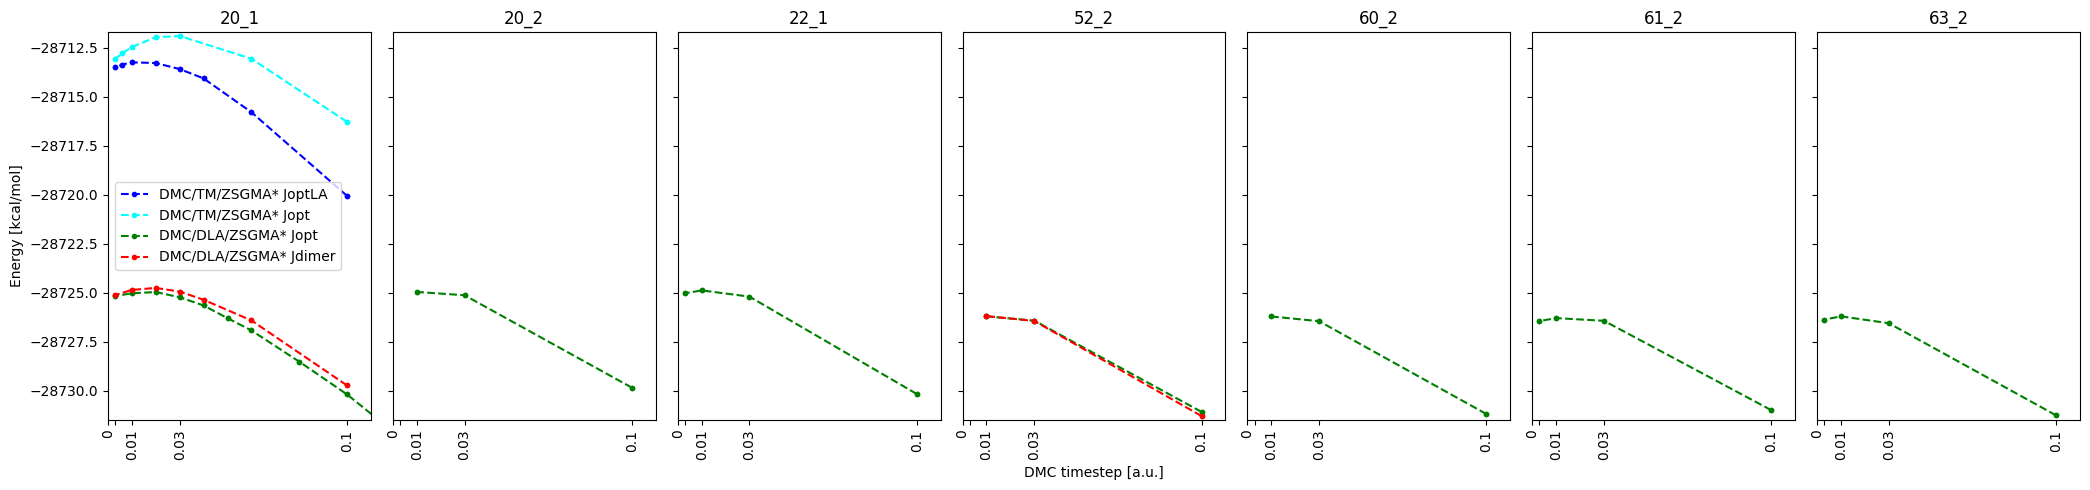

In [12]:
verbose = False

mol = 'AcOH'
#mol = 'Uracil'
#mol = 'Water'


mol_ids = list( results_mol[mol].keys() )
mol_ids.sort()
print(mol_ids)

nplots = len( mol_ids )
fig, ax = plt.subplots(1,nplots, sharey=True, figsize=(3*nplots, 5))

enemin=0.0
enemax=-1e6
#for mol in mol_names[:1]:
for idx, mol_id in enumerate( mol_ids ):
        print( f'Doing mol_id={mol_id}, idx={idx}' )
        ax[idx].set_title(f'{mol_id}')
        ax[idx].set_xlim([0,0.11])

        for dmc_type in results_mol[mol][mol_id].keys():
            for dmc_Jas in results_mol[mol][mol_id][dmc_type].keys():
                data = results_mol[mol][mol_id][dmc_type][dmc_Jas]
                taus = data.keys()
                if verbose: print( f'\n{mol} {mol_id} {dmc_type} {dmc_Jas} {len(taus)} tau {taus}' )
                df = pd.DataFrame( data ).transpose()
                df.index = [float(tau) for tau in df.index]
                df.sort_index(ascending=False, inplace=True)
                #df.astype({'ene':'float'}).dtypes
                if verbose: print( df[['ene','err']] )
                
                ax[idx].set_xlim([0.,0.11])
                ax[idx].set_xticklabels(labels=['0','','0.01','0.03','0.1'],rotation=90)
                ax[idx].set_xticks(ticks=[0,0.003, 0.01, 0.03, 0.1])
                try:
                    taus = np.array( df.index, dtype=np.double )
                    enes = np.array( df['ene'], dtype=np.double )
                    errs = np.array( df['err'], dtype=np.double )
                    c = dmc_color( dmc_type, dmc_Jas )
                    ax[idx].plot( taus, enes, '.--', label=f'{map_DMC(dmc_type)} {dmc_Jas}', color=c )
                    ax[idx].errorbar( taus, enes, errs, color=c, fmt='.' )
                except:
                    pass
                thismin = min(np.array( df[ df.index<0.11 ]['ene'], dtype=np.double ))
                thismax = max(np.array( df[ df.index<0.11 ]['ene'], dtype=np.double ))
                if enemin > thismin: 
                    enemin = thismin
                    if verbose: print(f'\n*** min={enemin}\tmax={enemax} // update min ***')
                if enemax < thismax:
                    enemax = thismax
                    if verbose: print(f'\n*** min={enemin}\tmax={enemax} // update max ***')

#ax[0].set_yticklabels(['{:,.0f}'.format(x) for x in ax[0].get_yticks()])
ax[0].set_ylabel('Energy [kcal/mol]')
ax[int( idx/2 )].set_xlabel('DMC timestep [a.u.]')

print(f'\n\nmin={enemin}\tmax={enemax}')
plt.ylim([enemin-0.2,enemax+0.2])
ax[0].legend()#loc='center left', bbox_to_anchor=(8.2, 0.5))
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()
fig.savefig(f'FIG02a/Multi_{mol}.png',format='png',dpi=300)

MOLECULE: Cyclopentane
['37_1', '38_1', '38_2', '39_2', '42_2']
Doing mol_id=37_1, idx=0
Doing mol_id=38_1, idx=1
Doing mol_id=38_2, idx=2
Doing mol_id=39_2, idx=3
Doing mol_id=42_2, idx=4


min=-21585.9607132952	max=-21585.300307536


/var/folders/6n/1hr7hr_s07557tv9vmdpt9c40000gn/T/ipykernel_20893/3434554976.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(labels=['0','','0.01','0.03','0.1'],rotation=90)
/var/folders/6n/1hr7hr_s07557tv9vmdpt9c40000gn/T/ipykernel_20893/3434554976.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(labels=['0','','0.01','0.03','0.1'],rotation=90)
/var/folders/6n/1hr7hr_s07557tv9vmdpt9c40000gn/T/ipykernel_20893/3434554976.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(labels=['0','','0.01','0.03','0.1'],rotation=90)
/var/folders/6n/1hr7hr_s07557tv9vmdpt9c40000gn/T/ipykernel_20893/3434554976.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(labels=['0','','0.01','0.03','0.1'],rotation=90)
/var/folders/6n/1hr7hr_s07557tv9vmdpt9c40000gn/T/ipykernel_20893/343

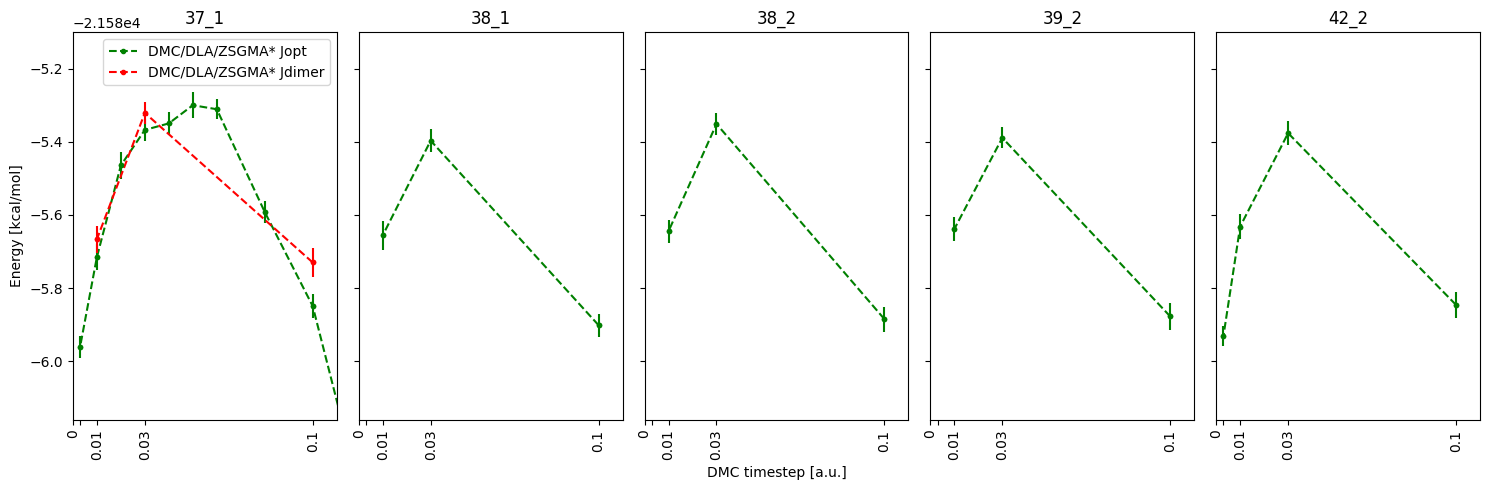

In [13]:
verbose = False

mol = mol_names[3]
print(f'MOLECULE: {mol}')

mol_ids = list( results_mol[mol].keys() )
mol_ids.sort()
print(mol_ids)

nplots = len( mol_ids )
fig, ax = plt.subplots(1,nplots, sharey=True, figsize=(3*nplots, 5))

enemin=0.0
enemax=-1e6
#for mol in mol_names[:1]:
for idx, mol_id in enumerate( mol_ids ):
        print( f'Doing mol_id={mol_id}, idx={idx}' )
        ax[idx].set_title(f'{mol_id}')
        ax[idx].set_xlim([0,0.11])

        for dmc_type in results_mol[mol][mol_id].keys():
            for dmc_Jas in results_mol[mol][mol_id][dmc_type].keys():
                data = results_mol[mol][mol_id][dmc_type][dmc_Jas]
                taus = data.keys()
                if verbose: print( f'\n{mol} {mol_id} {dmc_type} {dmc_Jas} {len(taus)} tau {taus}' )
                df = pd.DataFrame( data ).transpose()
                df.index = [float(tau) for tau in df.index]
                df.sort_index(ascending=False, inplace=True)
                #df.astype({'ene':'float'}).dtypes
                if verbose: print( df[['ene','err']] )
                
                ax[idx].set_xlim([0.,0.11])
                ax[idx].set_xticklabels(labels=['0','','0.01','0.03','0.1'],rotation=90)
                ax[idx].set_xticks(ticks=[0,0.003, 0.01, 0.03, 0.1])
                try:
                    taus = np.array( df.index, dtype=np.double )
                    enes = np.array( df['ene'], dtype=np.double )
                    errs = np.array( df['err'], dtype=np.double )
                    c = dmc_color( dmc_type, dmc_Jas )
                    ax[idx].plot( taus, enes, '.--', label=f'{map_DMC(dmc_type)} {dmc_Jas}', color=c )
                    ax[idx].errorbar( taus, enes, errs, color=c, fmt='.' )
                except:
                    pass
                thismin = min(np.array( df[ df.index<0.11 ]['ene'], dtype=np.double ))
                thismax = max(np.array( df[ df.index<0.11 ]['ene'], dtype=np.double ))
                if enemin > thismin: 
                    enemin = thismin
                    if verbose: print(f'\n*** min={enemin}\tmax={enemax} // update min ***')
                if enemax < thismax:
                    enemax = thismax
                    if verbose: print(f'\n*** min={enemin}\tmax={enemax} // update max ***')

#ax[0].set_yticklabels(['{:,.0f}'.format(x) for x in ax[0].get_yticks()])
ax[0].set_ylabel('Energy [kcal/mol]')
ax[int( idx/2 )].set_xlabel('DMC timestep [a.u.]')

print(f'\n\nmin={enemin}\tmax={enemax}')
plt.ylim([enemin-0.2,enemax+0.2])
ax[0].legend() #loc='center left', bbox_to_anchor=(nplots+1, 0.5))
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()
fig.savefig(f'FIG02a/Multi_{mol}.png',format='png',dpi=300)

MOLECULE: Peptide
['04_2', '07_2', '11_2', '13_1', '14_1', '15_1', '15_2', '16_1', '46_1', '57_2', '64_1']
Doing mol_id=04_2, idx=0
Doing mol_id=07_2, idx=1
Doing mol_id=11_2, idx=2
Doing mol_id=13_1, idx=3
Doing mol_id=14_1, idx=4


/var/folders/6n/1hr7hr_s07557tv9vmdpt9c40000gn/T/ipykernel_20893/2600240068.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(labels=['0','','0.01','0.03','0.1'],rotation=90)
/var/folders/6n/1hr7hr_s07557tv9vmdpt9c40000gn/T/ipykernel_20893/2600240068.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(labels=['0','','0.01','0.03','0.1'],rotation=90)
/var/folders/6n/1hr7hr_s07557tv9vmdpt9c40000gn/T/ipykernel_20893/2600240068.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(labels=['0','','0.01','0.03','0.1'],rotation=90)
/var/folders/6n/1hr7hr_s07557tv9vmdpt9c40000gn/T/ipykernel_20893/2600240068.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(labels=['0','','0.01','0.03','0.1'],rotation=90)
/var/folders/6n/1hr7hr_s07557tv9vmdpt9c40000gn/T/ipykernel_20893/260

Doing mol_id=15_1, idx=5
Doing mol_id=15_2, idx=6
Doing mol_id=16_1, idx=7
Doing mol_id=46_1, idx=8
Doing mol_id=57_2, idx=9
Doing mol_id=64_1, idx=10


min=-29607.9315781318	max=-29603.8025050399


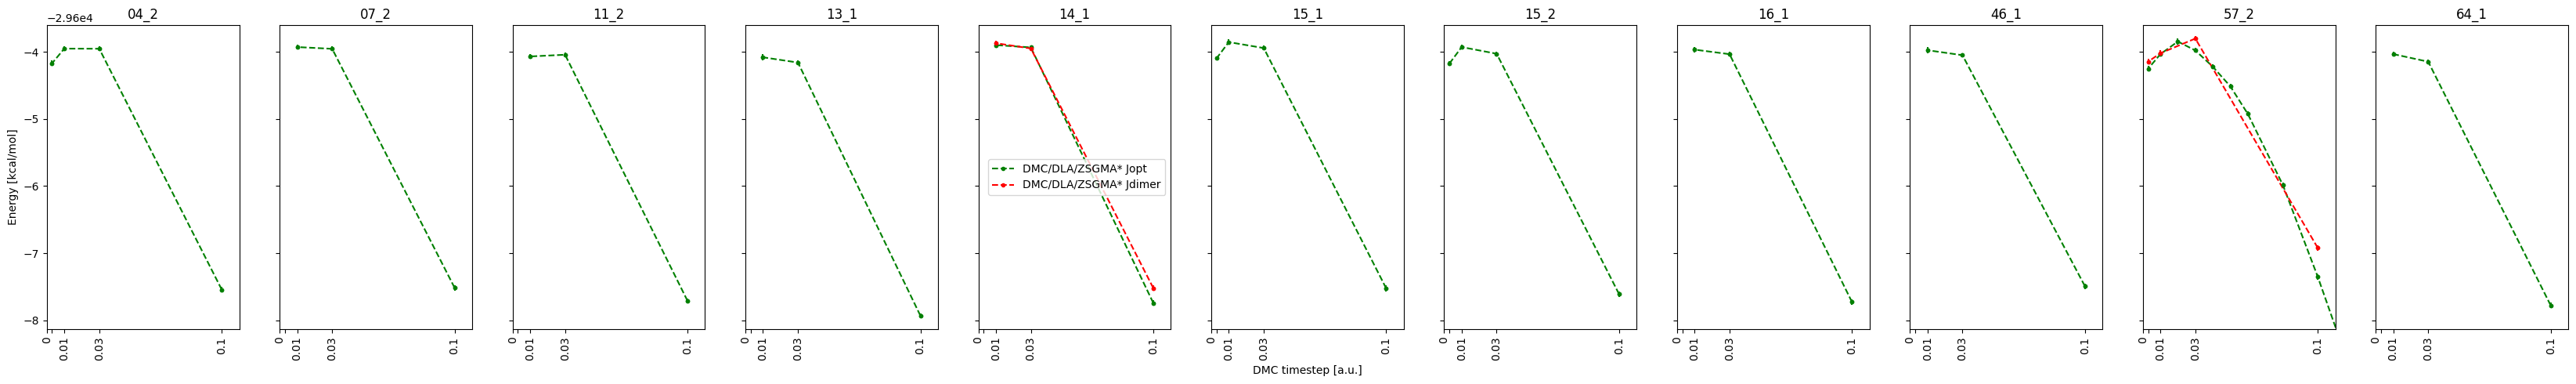

In [14]:
verbose = False

mol = mol_names[10]
print(f'MOLECULE: {mol}')

mol_ids = list( results_mol[mol].keys() )
mol_ids.sort()
print(mol_ids)

nplots = len( mol_ids )
fig, ax = plt.subplots(1,nplots, sharey=True, figsize=(3*nplots, 5))

enemin=0.0
enemax=-1e6
#for mol in mol_names[:1]:
for idx, mol_id in enumerate( mol_ids ):
        print( f'Doing mol_id={mol_id}, idx={idx}' )
        ax[idx].set_title(f'{mol_id}')
        ax[idx].set_xlim([0,0.11])

        for dmc_type in results_mol[mol][mol_id].keys():
            for dmc_Jas in results_mol[mol][mol_id][dmc_type].keys():
                data = results_mol[mol][mol_id][dmc_type][dmc_Jas]
                taus = data.keys()
                if verbose: print( f'\n{mol} {mol_id} {dmc_type} {dmc_Jas} {len(taus)} tau {taus}' )
                df = pd.DataFrame( data ).transpose()
                df.index = [float(tau) for tau in df.index]
                df.sort_index(ascending=False, inplace=True)
                #df.astype({'ene':'float'}).dtypes
                if verbose: print( df[['ene','err']] )
                
                ax[idx].set_xlim([0.,0.11])
                ax[idx].set_xticklabels(labels=['0','','0.01','0.03','0.1'],rotation=90)
                ax[idx].set_xticks(ticks=[0,0.003, 0.01, 0.03, 0.1])
                try:
                    taus = np.array( df.index, dtype=np.double )
                    enes = np.array( df['ene'], dtype=np.double )
                    errs = np.array( df['err'], dtype=np.double )
                    c = dmc_color( dmc_type, dmc_Jas )
                    ax[idx].plot( taus, enes, '.--', label=f'{map_DMC(dmc_type)} {dmc_Jas}', color=c )
                    ax[idx].errorbar( taus, enes, errs, color=c, fmt='.' )
                except:
                    pass
                thismin = min(np.array( df[ df.index<0.11 ]['ene'], dtype=np.double ))
                thismax = max(np.array( df[ df.index<0.11 ]['ene'], dtype=np.double ))
                if enemin > thismin: 
                    enemin = thismin
                    if verbose: print(f'\n*** min={enemin}\tmax={enemax} // update min ***')
                if enemax < thismax:
                    enemax = thismax
                    if verbose: print(f'\n*** min={enemin}\tmax={enemax} // update max ***')

#ax[0].set_yticklabels(['{:,.0f}'.format(x) for x in ax[0].get_yticks()])
ax[0].set_ylabel('Energy [kcal/mol]')
ax[int( idx/2 )].set_xlabel('DMC timestep [a.u.]')

print(f'\n\nmin={enemin}\tmax={enemax}')
plt.ylim([enemin-0.2,enemax+0.2])
ax[4].legend() #loc='center left', bbox_to_anchor=(8, 0.5))
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()
fig.savefig(f'FIG02a/Multi_{mol}.png',format='png',dpi=300)

MOLECULE: Uracil
['17_1', '17_2', '22_2', '23_2', '26_1', '26_2', '28_2', '29_2', '31_1', '32_1', '41_1', '42_1', '43_1']
Doing mol_id=17_1, idx=0
Doing mol_id=17_2, idx=1
Doing mol_id=22_2, idx=2
Doing mol_id=23_2, idx=3
Doing mol_id=26_1, idx=4
Doing mol_id=26_2, idx=5
Doing mol_id=28_2, idx=6
Doing mol_id=29_2, idx=7
Doing mol_id=31_1, idx=8
Doing mol_id=32_1, idx=9
Doing mol_id=41_1, idx=10
Doing mol_id=42_1, idx=11
Doing mol_id=43_1, idx=12


/var/folders/6n/1hr7hr_s07557tv9vmdpt9c40000gn/T/ipykernel_20893/64855671.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(labels=['0','','0.01','0.03','0.1'],rotation=90)
/var/folders/6n/1hr7hr_s07557tv9vmdpt9c40000gn/T/ipykernel_20893/64855671.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(labels=['0','','0.01','0.03','0.1'],rotation=90)
/var/folders/6n/1hr7hr_s07557tv9vmdpt9c40000gn/T/ipykernel_20893/64855671.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(labels=['0','','0.01','0.03','0.1'],rotation=90)
/var/folders/6n/1hr7hr_s07557tv9vmdpt9c40000gn/T/ipykernel_20893/64855671.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(labels=['0','','0.01','0.03','0.1'],rotation=90)
/var/folders/6n/1hr7hr_s07557tv9vmdpt9c40000gn/T/ipykernel_20893/64855671.py



min=-48315.9231179452	max=-48308.0453634375


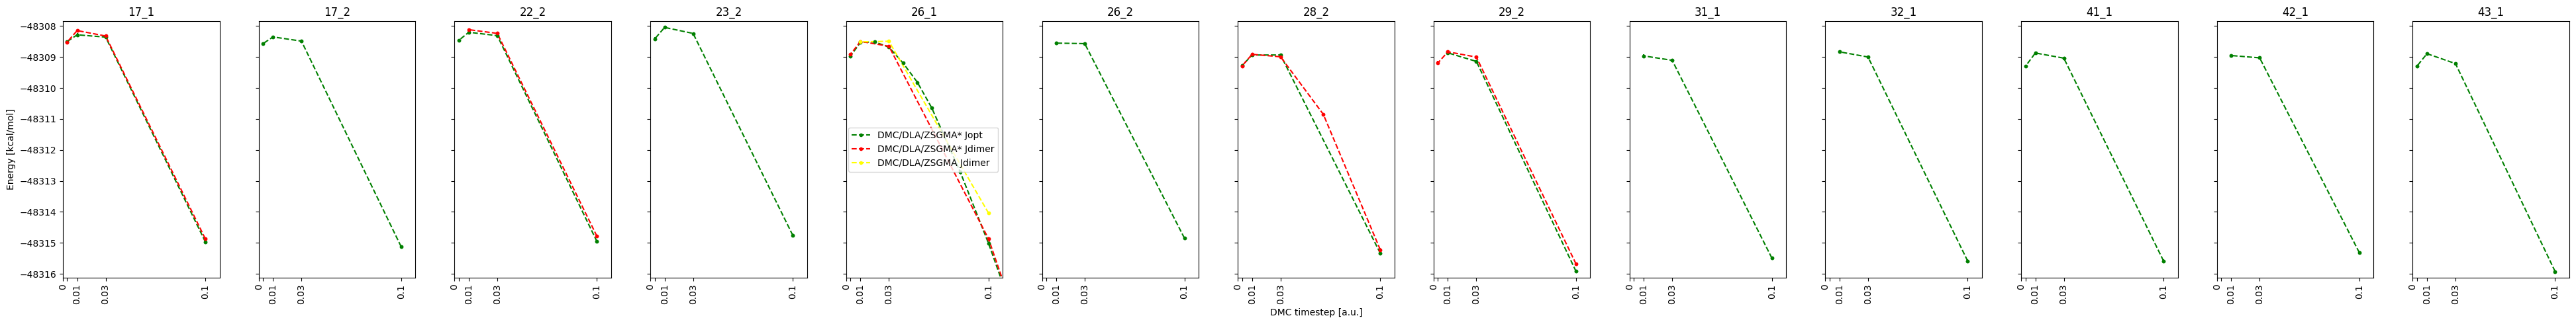

In [15]:
verbose = False

mol = mol_names[12]
print(f'MOLECULE: {mol}')

mol_ids = list( results_mol[mol].keys() )
mol_ids.sort()
print(mol_ids)

nplots = len( mol_ids )
fig, ax = plt.subplots(1,nplots, sharey=True, figsize=(3*nplots, 5))

enemin=0.0
enemax=-1e6
#for mol in mol_names[:1]:
for idx, mol_id in enumerate( mol_ids ):
        print( f'Doing mol_id={mol_id}, idx={idx}' )
        ax[idx].set_title(f'{mol_id}')
        ax[idx].set_xlim([0,0.11])

        for dmc_type in results_mol[mol][mol_id].keys():
            for dmc_Jas in results_mol[mol][mol_id][dmc_type].keys():
                data = results_mol[mol][mol_id][dmc_type][dmc_Jas]
                taus = data.keys()
                if verbose: print( f'\n{mol} {mol_id} {dmc_type} {dmc_Jas} {len(taus)} tau {taus}' )
                df = pd.DataFrame( data ).transpose()
                df.index = [float(tau) for tau in df.index]
                df.sort_index(ascending=False, inplace=True)
                #df.astype({'ene':'float'}).dtypes
                if verbose: print( df[['ene','err']] )
                
                ax[idx].set_xlim([0.,0.11])
                ax[idx].set_xticklabels(labels=['0','','0.01','0.03','0.1'],rotation=90)
                ax[idx].set_xticks(ticks=[0,0.003, 0.01, 0.03, 0.1])
                try:
                    taus = np.array( df.index, dtype=np.double )
                    enes = np.array( df['ene'], dtype=np.double )
                    errs = np.array( df['err'], dtype=np.double )
                    c = dmc_color( dmc_type, dmc_Jas )
                    ax[idx].plot( taus, enes, '.--', label=f'{map_DMC(dmc_type)} {dmc_Jas}', color=c )
                    ax[idx].errorbar( taus, enes, errs, color=c, fmt='.' )
                except:
                    pass
                thismin = min(np.array( df[ df.index<0.11 ]['ene'], dtype=np.double ))
                thismax = max(np.array( df[ df.index<0.11 ]['ene'], dtype=np.double ))
                if enemin > thismin: 
                    enemin = thismin
                    if verbose: print(f'\n*** min={enemin}\tmax={enemax} // update min ***')
                if enemax < thismax:
                    enemax = thismax
                    if verbose: print(f'\n*** min={enemin}\tmax={enemax} // update max ***')

#ax[0].set_yticklabels(['{:,.1f}'.format(x) for x in ax[0].get_yticks()])
ax[0].set_ylabel('Energy [kcal/mol]')
ax[int( idx/2 )].set_xlabel('DMC timestep [a.u.]')

print(f'\n\nmin={enemin}\tmax={enemax}')
plt.ylim([enemin-0.2,enemax+0.2])
ax[4].legend()#loc='center left', bbox_to_anchor=(10.7, 0.5))
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()
fig.savefig(f'FIG02a/Multi_{mol}.png',format='png',dpi=300)

MOLECULE: AcNH2
Doing mol_id=21_1, idx=0


min=-25307.0175734016	max=-25289.8404503845
MOLECULE: AcOH
Doing mol_id=20_1, idx=1


min=-28750.4800399658	max=-28711.8893219169
MOLECULE: Benzene
Doing mol_id=24_1, idx=2


min=-23630.9109449211	max=-23623.6181140606
MOLECULE: Cyclopentane
Doing mol_id=37_1, idx=3


min=-21591.9848935531	max=-21585.300307536
MOLECULE: Ethene
Doing mol_id=30_2, idx=4


min=-8612.69843627199	max=-8610.06095084733
MOLECULE: Ethyne
Doing mol_id=32_2, idx=5


min=-7825.12426495639	max=-7822.76712243925
MOLECULE: MeNH2
Doing mol_id=56_2, idx=6


min=-11676.3734497103	max=-11671.1312241955
MOLECULE: MeOH
Doing mol_id=55_2, idx=7


min=-15117.3247880128	max=-15103.6217561976
MOLECULE: Neopentane
Doing mol_id=36_1, idx=8


min=-22355.9938191636	max=-22349.2279630765
MOLECULE: Pentane
Doing mol_id=34_1, idx=9


min=-22353.2324156415	max=-22345.9779753179
MOLECULE: Peptide
Doing mol_id=57_2, idx=10


min=-29623.6295250469	max=-29603.8025050399
MOLECULE: Pyridine
Doing 

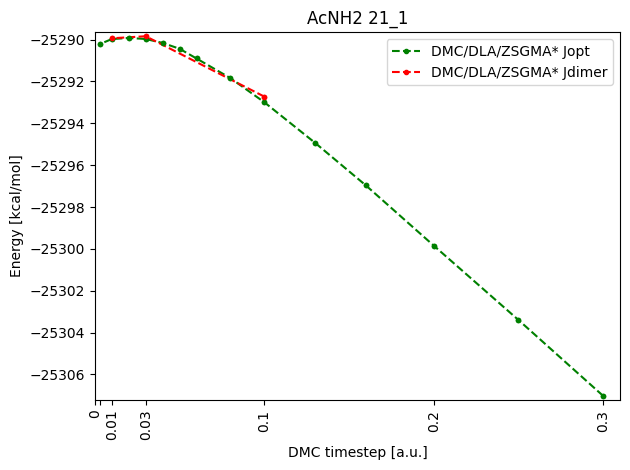

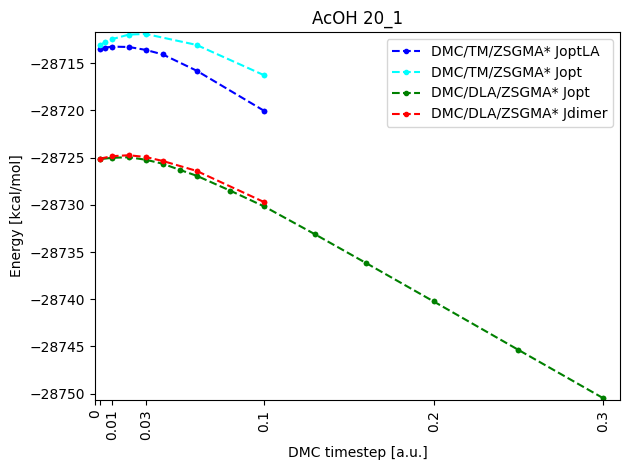

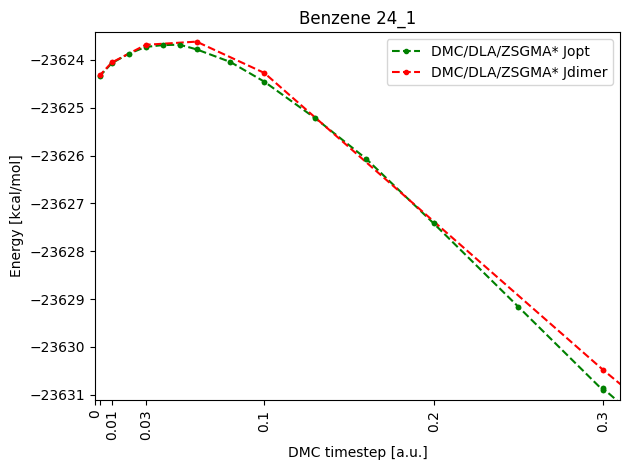

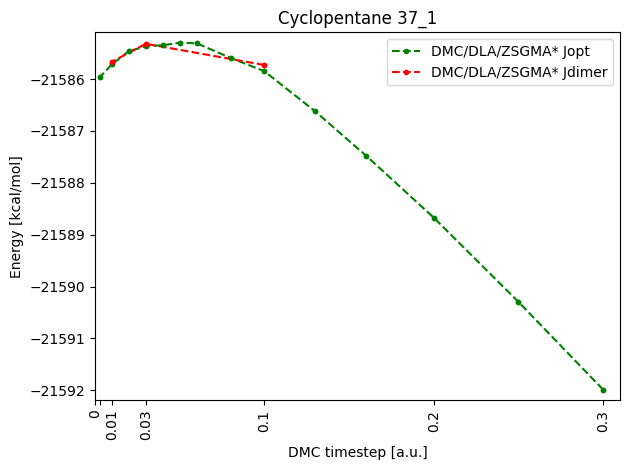

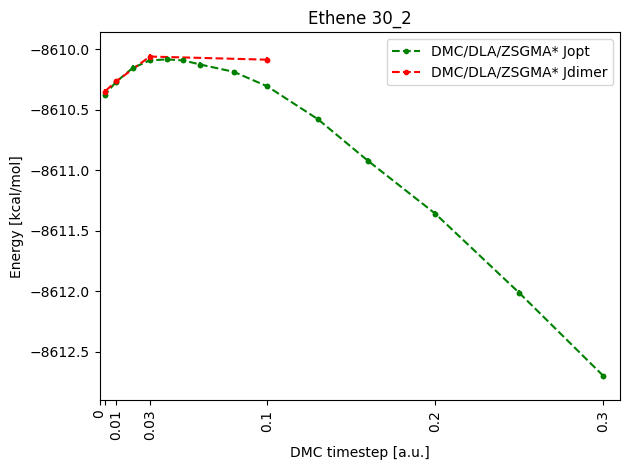

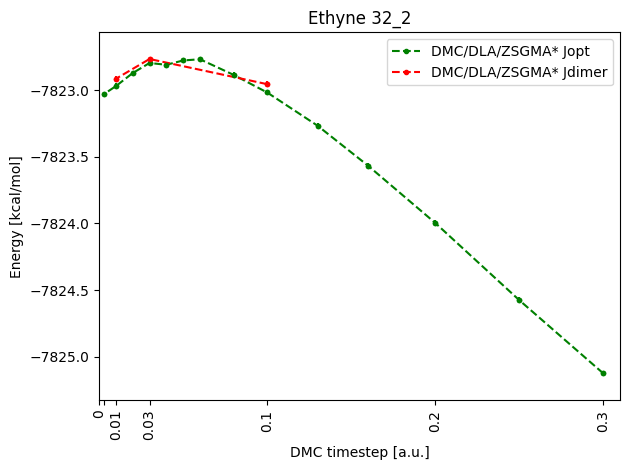

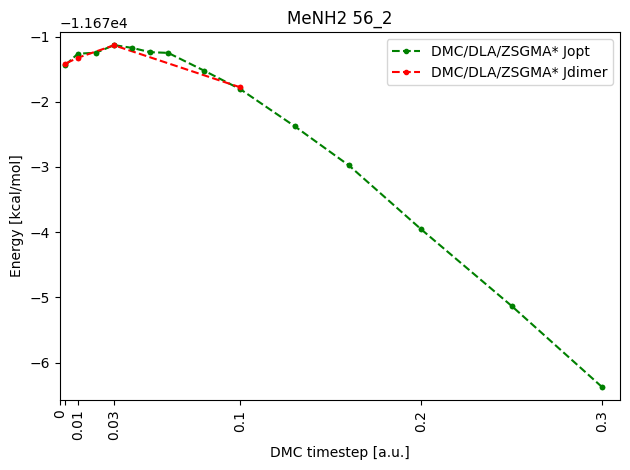

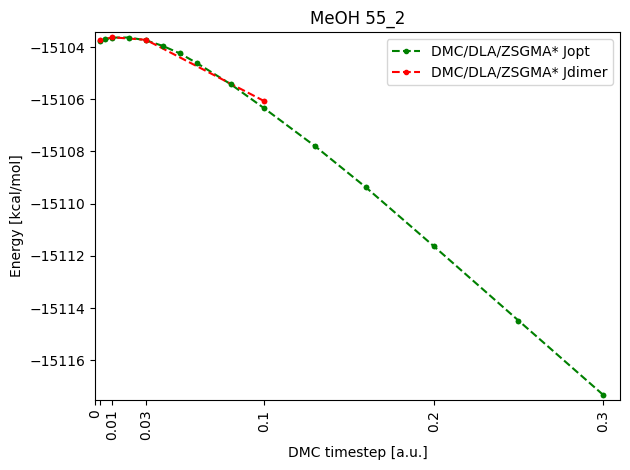

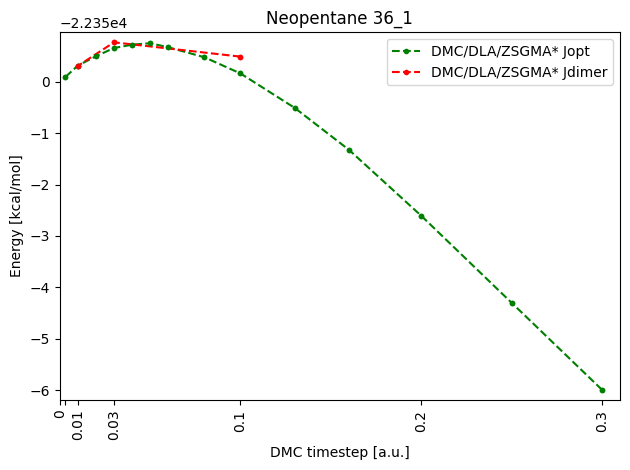

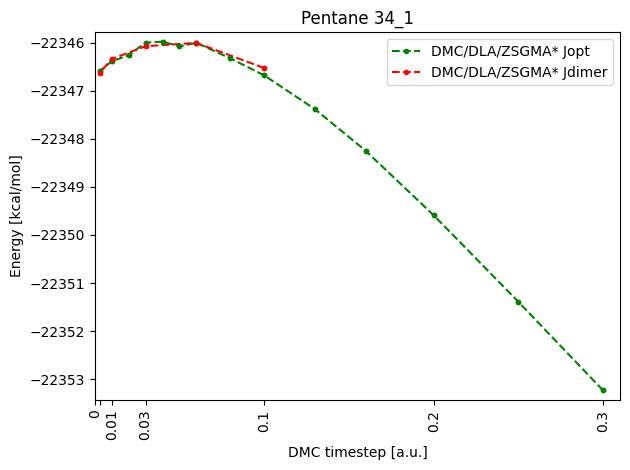

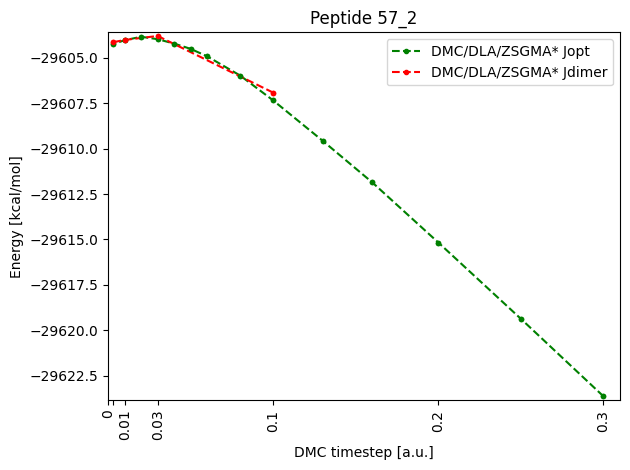

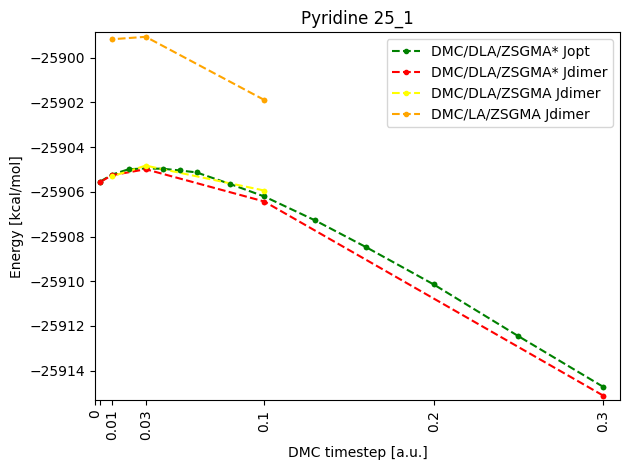

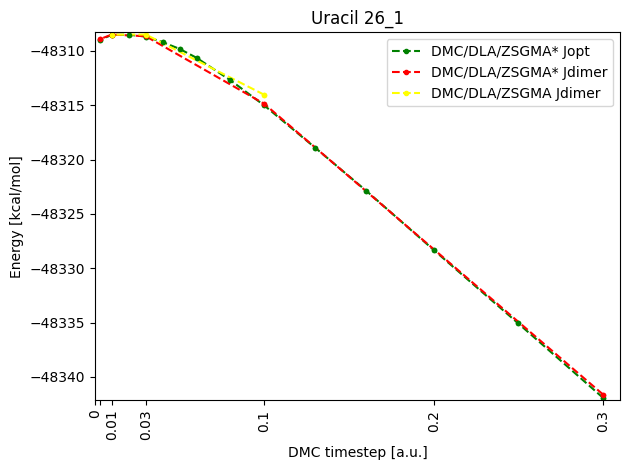

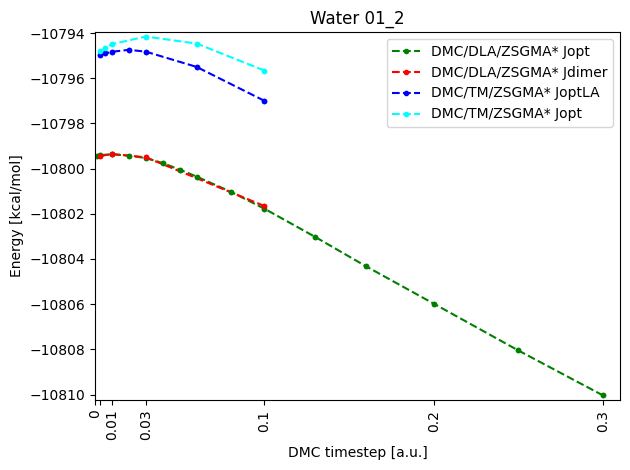

In [16]:
# Plot total energy for representative molecules
verbose = False

xmax = 0.31
for idx, mol in enumerate( mol_names ):
    print(f'MOLECULE: {mol}')
    mol_id = mol_info[mol]['ref']
    print( f'Doing mol_id={mol_id}, idx={idx}' )

    fig, ax = plt.subplots() # figsize=(10, 15) )
    ax.set_title(f'{mol} {mol_id}')

    ax.set_xlim([0.,xmax])
    ax.set_xticks(ticks=[0,0.003, 0.01, 0.03, 0.1, 0.2, 0.3])
    ax.set_xticklabels(labels=['0','','0.01','0.03','0.1','0.2','0.3'],rotation=90)

    ax.set_ylabel('Energy [kcal/mol]')
    ax.set_xlabel('DMC timestep [a.u.]')

    enemin=0.0
    enemax=-1e6
    for dmc_type in results_mol[mol][mol_id].keys():
        for dmc_Jas in results_mol[mol][mol_id][dmc_type].keys():
            data = results_mol[mol][mol_id][dmc_type][dmc_Jas]
            taus = data.keys()

            if verbose: 
                print( f'\n{mol} {mol_id} {dmc_type} {dmc_Jas} {len(taus)} tau {taus}' )

            df = pd.DataFrame( data ).transpose()
            df.index = [float(tau) for tau in df.index]
            df.sort_index(ascending=False, inplace=True)
            #df.astype({'ene':'float'}).dtypes

            if verbose: 
                print( df[['ene','err']] )

            try:
                taus = np.array( df.index, dtype=np.double )
                enes = np.array( df['ene'], dtype=np.double )
                errs = np.array( df['err'], dtype=np.double )
                c = dmc_color( dmc_type, dmc_Jas )
                ax.plot( taus, enes, '.--', label=f'{map_DMC(dmc_type)} {dmc_Jas}', color=c )
                ax.errorbar( taus, enes, errs, color=c, fmt='.' )
            except:
                pass
            thismin = min(np.array( df[ df.index<xmax ]['ene'], dtype=np.double ))
            thismax = max(np.array( df[ df.index<xmax ]['ene'], dtype=np.double ))
            if enemin > thismin: 
                enemin = thismin
                if verbose: print(f'\n*** min={enemin}\tmax={enemax} // update min ***')
            if enemax < thismax:
                enemax = thismax
                if verbose: print(f'\n*** min={enemin}\tmax={enemax} // update max ***')

    print(f'\n\nmin={enemin}\tmax={enemax}')
    plt.ylim([enemin-0.2,enemax+0.2])
    #ax.set_yticklabels(['{:,.0f}'.format(x) for x in ax.get_yticks()])

    ax.legend()#loc='center left', bbox_to_anchor=(10.7, 0.5))

    fig.tight_layout()
    fig.savefig(f'FIG02a/Energy_{mol}.png',format='png',dpi=300)

MOLECULE: AcNH2
Doing mol_id=21_1, idx=0


min=0.0	max=0.6298845097203075
MOLECULE: AcOH
Doing mol_id=20_1, idx=1


min=0.0	max=0.8425528556547864
MOLECULE: Benzene
Doing mol_id=24_1, idx=2


min=0.0	max=0.5196593210319735
MOLECULE: Cyclopentane
Doing mol_id=37_1, idx=3


min=0.0	max=0.45585271326927546
MOLECULE: Ethene
Doing mol_id=30_2, idx=4


min=0.0	max=0.16950438641928794
MOLECULE: Ethyne
Doing mol_id=32_2, idx=5


min=0.0	max=0.1475797912191901
MOLECULE: MeNH2
Doing mol_id=56_2, idx=6


min=0.0	max=0.2601601268771546
MOLECULE: MeOH
Doing mol_id=55_2, idx=7


min=0.0	max=0.3855301147135004
MOLECULE: Neopentane
Doing mol_id=36_1, idx=8


min=0.0	max=0.4649995239678556
MOLECULE: Pentane
Doing mol_id=34_1, idx=9


min=0.0	max=0.4612014863243017
MOLECULE: Peptide
Doing mol_id=57_2, idx=10


min=0.0	max=0.7468226793377383
MOLECULE: Pyridine
Doing mol_id=25_1, idx=11


min=0.0	max=0.6451069963387981
MOLECULE: Uracil
Doing mol_id=26_1, idx=12


min=0.0	max=1.2823502529393422
MOLECULE: W

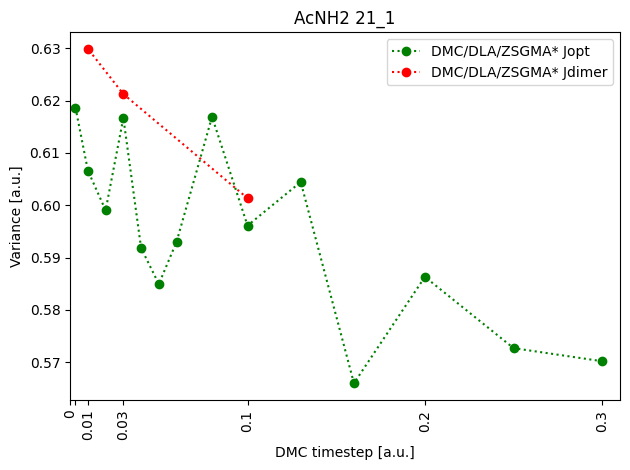

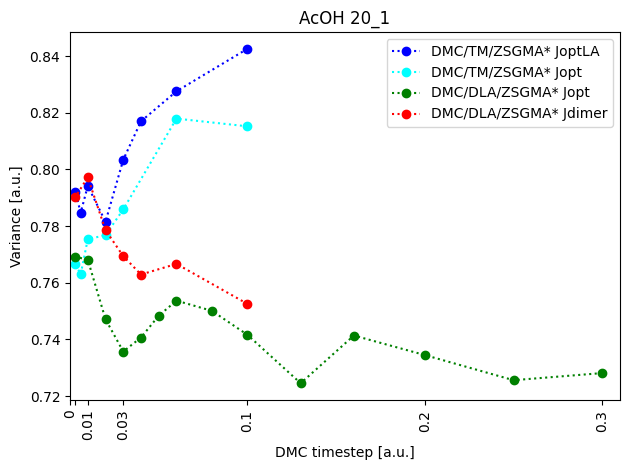

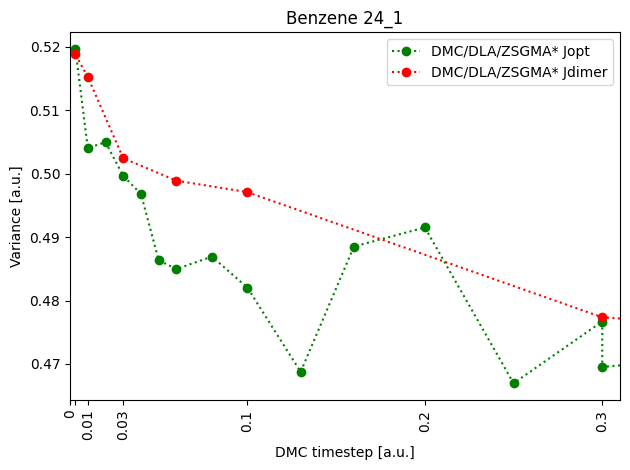

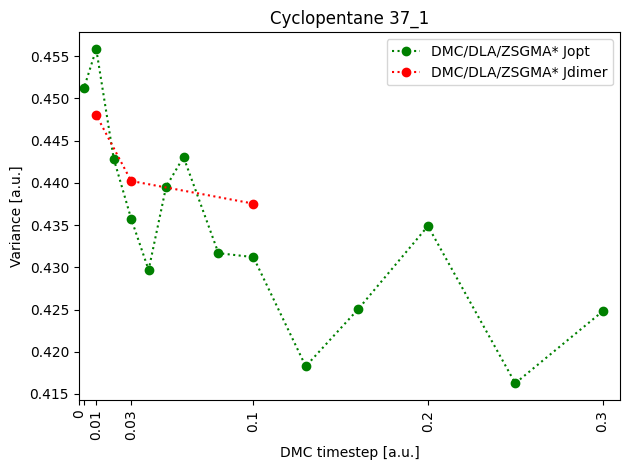

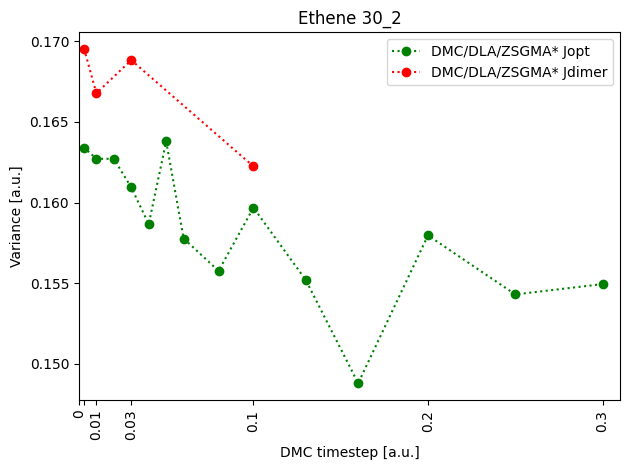

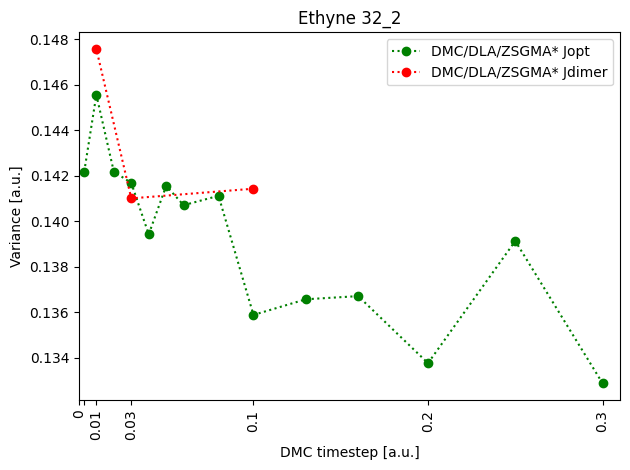

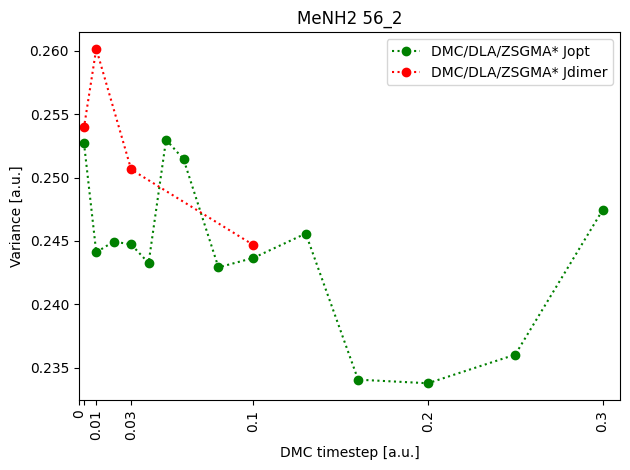

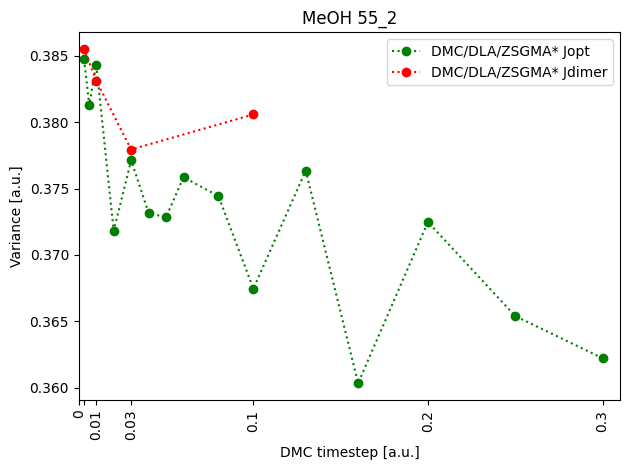

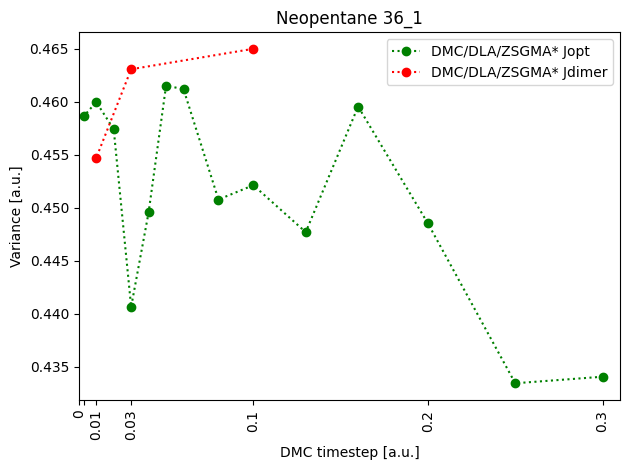

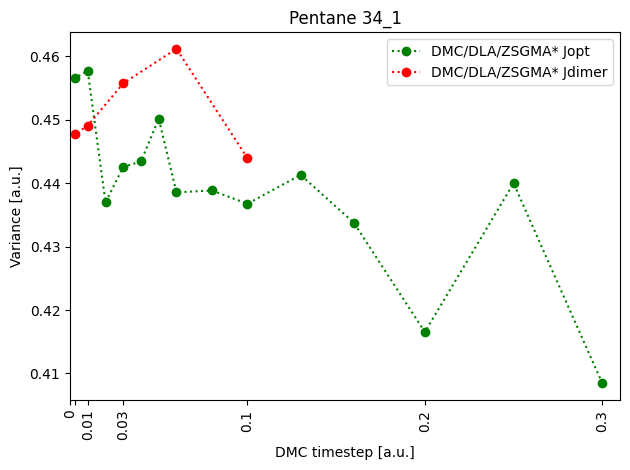

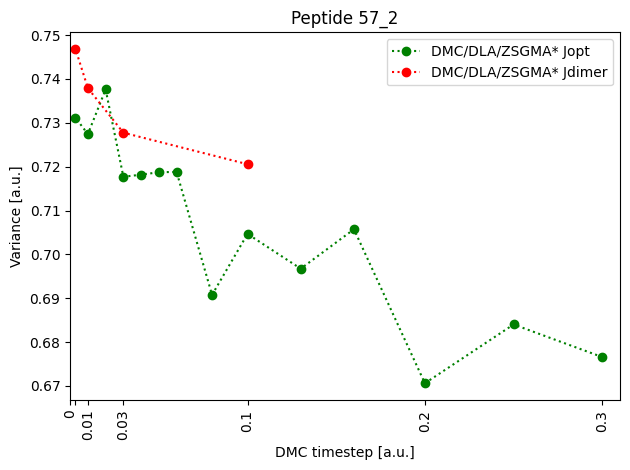

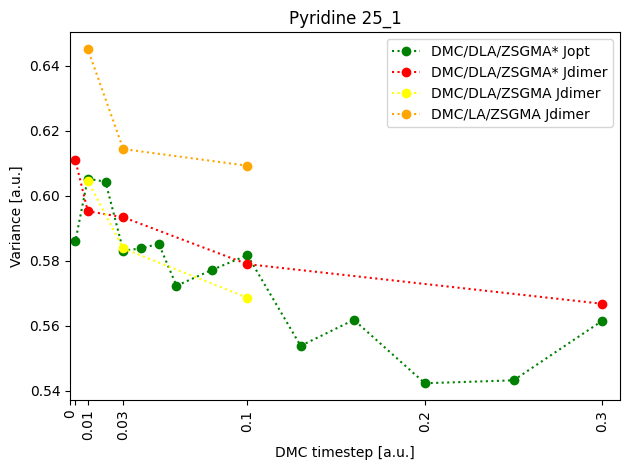

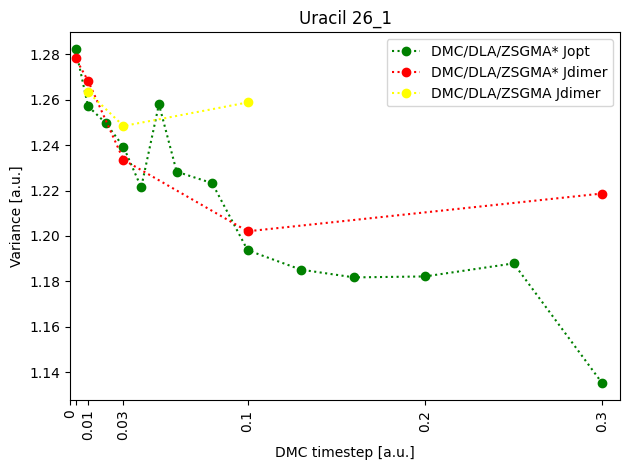

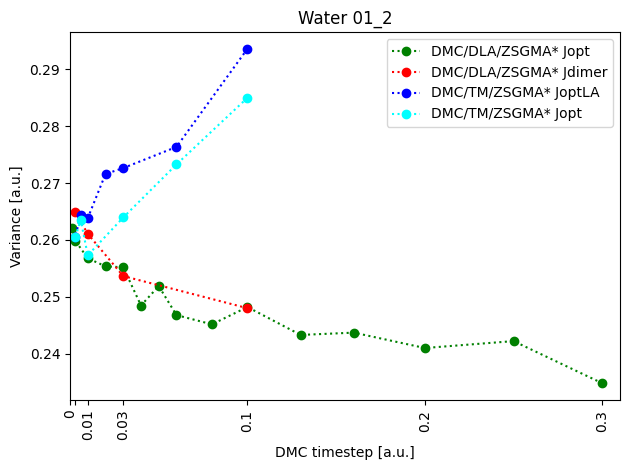

In [17]:
# Plot Variance for representative molecules
verbose = False

xmax = 0.31
for idx, mol in enumerate( mol_names ):
    print(f'MOLECULE: {mol}')
    mol_id = mol_info[mol]['ref']
    print( f'Doing mol_id={mol_id}, idx={idx}' )

    fig, ax = plt.subplots() # figsize=(10, 15) )
    ax.set_title(f'{mol} {mol_id}')

    ax.set_xlim([0.,xmax])
    ax.set_xticks(ticks=[0,0.003, 0.01, 0.03, 0.1, 0.2, 0.3])
    ax.set_xticklabels(labels=['0','','0.01','0.03','0.1','0.2','0.3'],rotation=90)

    ax.set_ylabel('Variance [a.u.]')
    ax.set_xlabel('DMC timestep [a.u.]')

    Ymin=0.0
    Ymax=-1e6
    for dmc_type in results_mol[mol][mol_id].keys():
        for dmc_Jas in results_mol[mol][mol_id][dmc_type].keys():
            data = results_mol[mol][mol_id][dmc_type][dmc_Jas]
            taus = data.keys()

            if verbose: 
                print( f'\n{mol} {mol_id} {dmc_type} {dmc_Jas} {len(taus)} tau {taus}' )

            df = pd.DataFrame( data ).transpose()
            df.index = [float(tau) for tau in df.index]
            df.sort_index(ascending=False, inplace=True)
            #df.astype({'ene':'float'}).dtypes

            if verbose: 
                print( df[['ene','err']] )

            try:
                taus = np.array( df.index, dtype=np.double )
                enes = np.array( df['ene'], dtype=np.double )
                errs = np.array( df['err'], dtype=np.double )
                VARs = np.array( df['Var[au]'], dtype=np.double )
                c = dmc_color( dmc_type, dmc_Jas )
                ax.plot( taus, VARs, 'o:', label=f'{map_DMC(dmc_type)} {dmc_Jas}', color=c )
                #ax.errorbar( taus, enes, errs, color=c, fmt='.' )
            except:
                pass
            thismin = min(np.array( df[ df.index<xmax ]['Var[au]'], dtype=np.double ))
            thismax = max(np.array( df[ df.index<xmax ]['Var[au]'], dtype=np.double ))
            if Ymin > thismin: 
                Ymin = thismin
                if verbose: print(f'\n*** min={Ymin}\tmax={Ymax} // update min ***')
            if Ymax < thismax:
                Ymax = thismax
                if verbose: print(f'\n*** min={Ymin}\tmax={Ymax} // update max ***')

    print(f'\n\nmin={Ymin}\tmax={Ymax}')
    #plt.ylim([0,Ymax*1.01])
    #ax.set_yticklabels(['{:,.0f}'.format(x) for x in ax.get_yticks()])

    ax.legend()#loc='center left', bbox_to_anchor=(10.7, 0.5))

    fig.tight_layout()
    fig.savefig(f'FIG02a/Variance_{mol}.png',format='png',dpi=300)

MOLECULE: AcNH2
Doing mol_id=21_1, idx=0
MOLECULE: AcOH
Doing mol_id=20_1, idx=1
MOLECULE: Benzene
Doing mol_id=24_1, idx=2
MOLECULE: Cyclopentane
Doing mol_id=37_1, idx=3
MOLECULE: Ethene
Doing mol_id=30_2, idx=4
MOLECULE: Ethyne
Doing mol_id=32_2, idx=5
MOLECULE: MeNH2
Doing mol_id=56_2, idx=6
MOLECULE: MeOH
Doing mol_id=55_2, idx=7
MOLECULE: Neopentane
Doing mol_id=36_1, idx=8
MOLECULE: Pentane
Doing mol_id=34_1, idx=9
MOLECULE: Peptide
Doing mol_id=57_2, idx=10
MOLECULE: Pyridine
Doing mol_id=25_1, idx=11
MOLECULE: Uracil
Doing mol_id=26_1, idx=12
MOLECULE: Water
Doing mol_id=01_2, idx=13


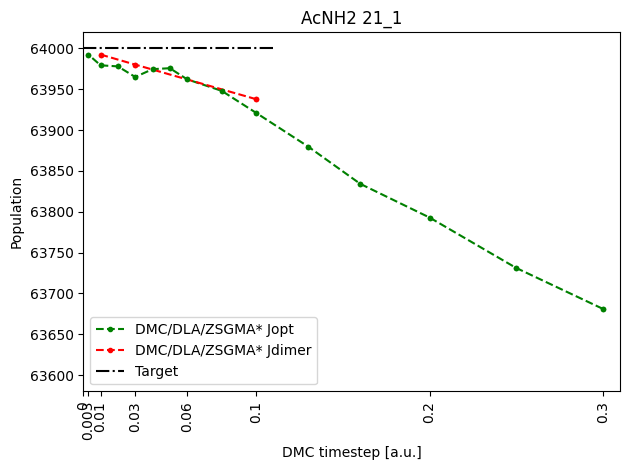

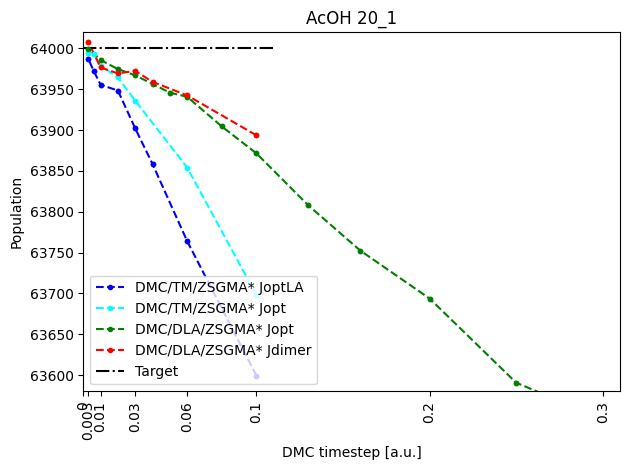

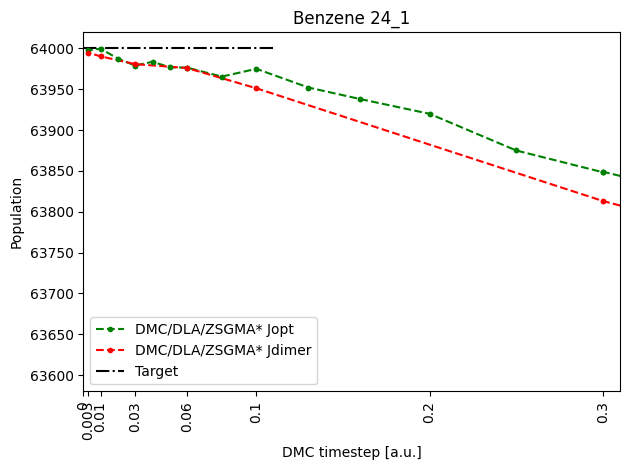

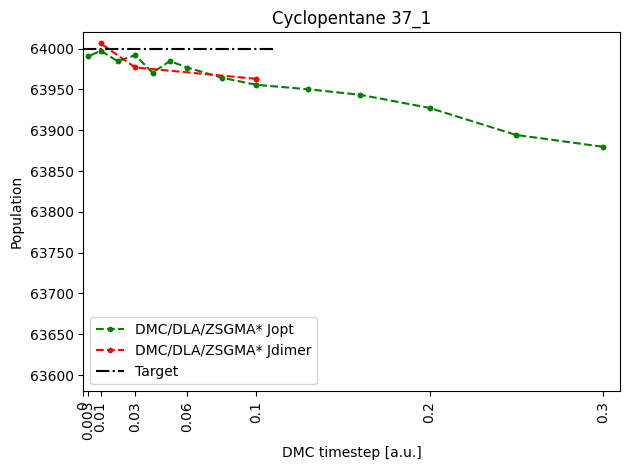

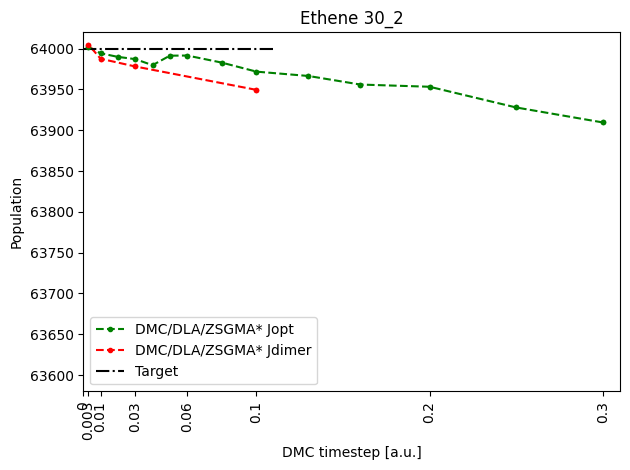

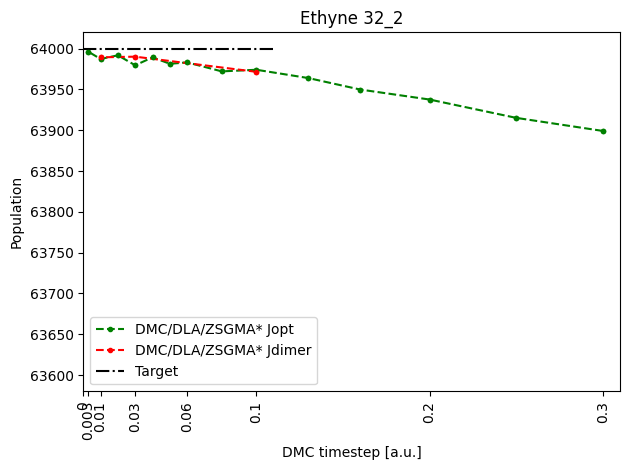

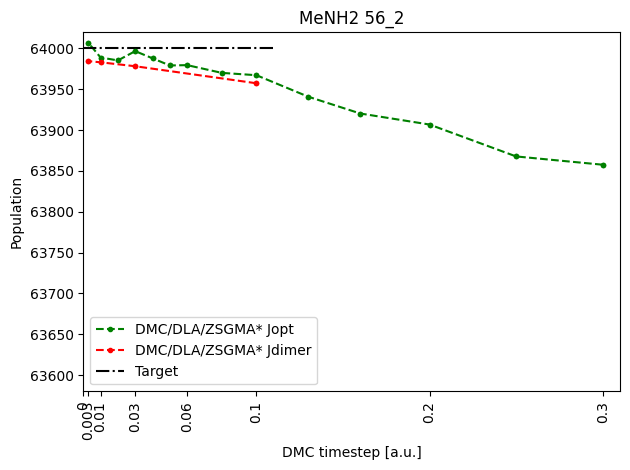

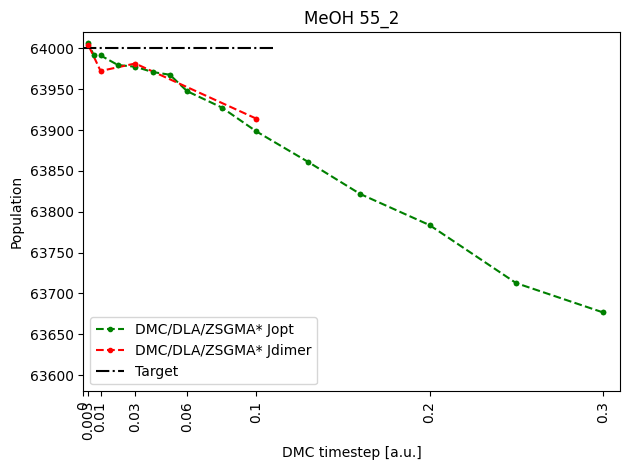

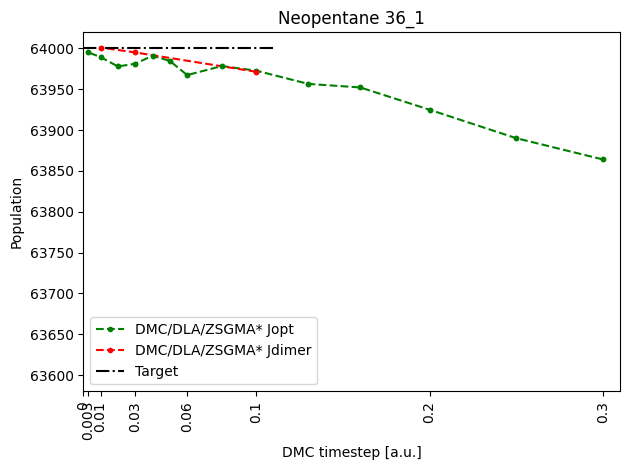

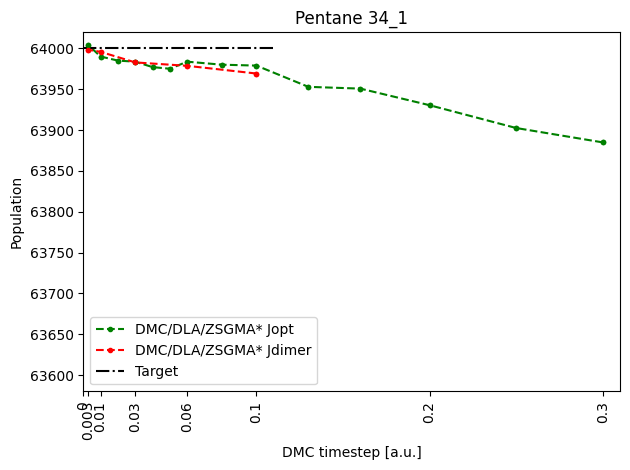

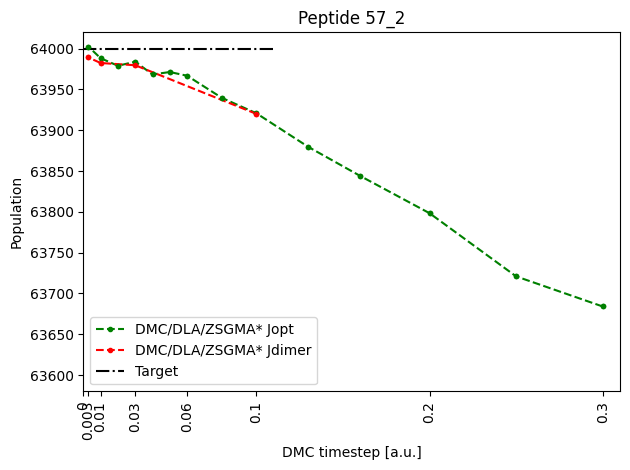

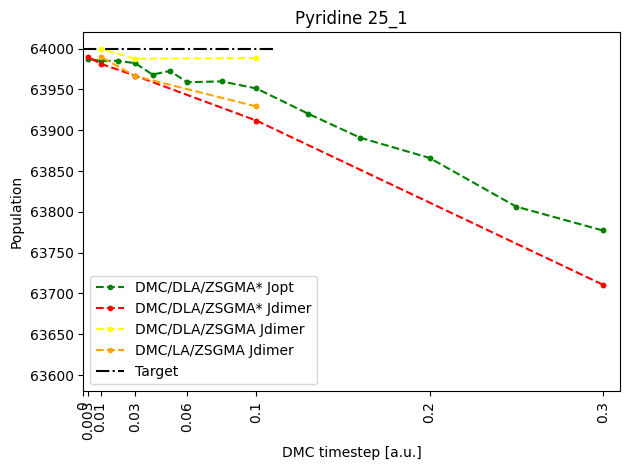

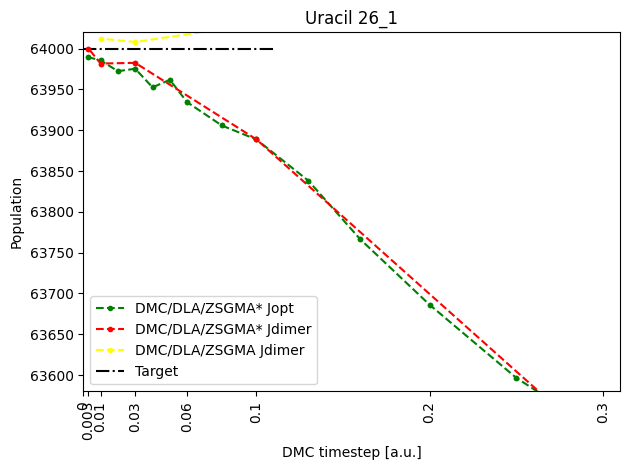

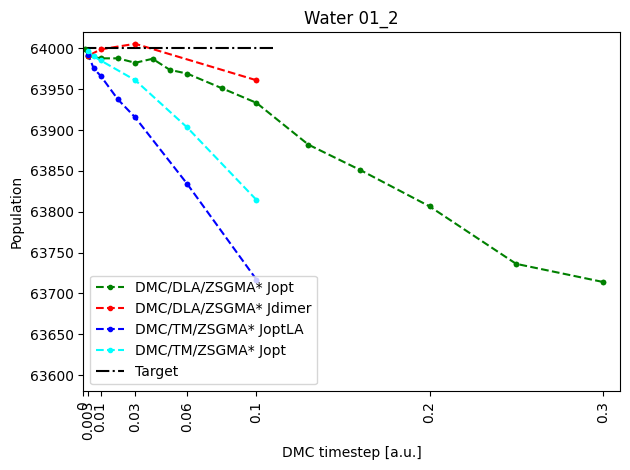

In [18]:
# Plot Population for representative molecules
verbose = False

xmax = 0.31
for idx, mol in enumerate( mol_names ):
    print(f'MOLECULE: {mol}')
    mol_id = mol_info[mol]['ref']
    print( f'Doing mol_id={mol_id}, idx={idx}' )

    fig, ax = plt.subplots() # figsize=(10, 15) )
    ax.set_title(f'{mol} {mol_id}')

    ax.set_xlim([0.,xmax])
    #ax.set_xticks(ticks=[0,0.003, 0.01, 0.03, 0.1, 0.2, 0.3])
    #ax.set_xticklabels(labels=['0','','0.01','0.03','0.1','0.2','0.3'],rotation=90)
    ticks=[0,0.003, 0.01, 0.03, 0.06, 0.1, 0.2, 0.3]
    ax.set_xticks(ticks=ticks)
    ax.set_xticklabels(labels=[str(i) for i in ticks],rotation=90)

    ax.set_ylabel('Population')
    ax.set_xlabel('DMC timestep [a.u.]')
    plt.ylim([63580,64020])
    #ax.set_yticklabels(['{:,.0f}'.format(x) for x in ax.get_yticks()])

    Ymin=1e6
    Ymax=-1e6
    for dmc_type in results_mol[mol][mol_id].keys():
        for dmc_Jas in results_mol[mol][mol_id][dmc_type].keys():
            data = results_mol[mol][mol_id][dmc_type][dmc_Jas]
            taus = data.keys()

            if verbose: 
                print( f'\n{mol} {mol_id} {dmc_type} {dmc_Jas} {len(taus)} tau {taus}' )

            df = pd.DataFrame( data ).transpose()
            df.index = [float(tau) for tau in df.index]
            df.sort_index(ascending=False, inplace=True)
            #df.astype({'ene':'float'}).dtypes

            if verbose: 
                print( df[['ene','err']] )

            try:
                taus = np.array( df.index, dtype=np.double )
                enes = np.array( df['ene'], dtype=np.double )
                errs = np.array( df['err'], dtype=np.double )
                Yname = 'Pop'
                Y = np.array( df[Yname], dtype=np.double )
                Yerr = np.array( df['Pop-err'], dtype=np.double )
                c = dmc_color( dmc_type, dmc_Jas )
                ax.plot( taus, Y, '.--', label=f'{map_DMC(dmc_type)} {dmc_Jas}', color=c )
                ax.errorbar( taus, Y, Yerr, color=c, fmt='.' )
            except:
                pass
            thismin = min(np.array( df[ df.index<xmax ][Yname], dtype=np.double ))
            thismax = max(np.array( df[ df.index<xmax ][Yname], dtype=np.double ))
            if Ymin > thismin: 
                Ymin = thismin
                if verbose: print(f'\n*** min={Ymin}\tmax={Ymax} // update min ***')
            if Ymax < thismax:
                Ymax = thismax
                if verbose: print(f'\n*** min={Ymin}\tmax={Ymax} // update max ***')

    ax.hlines(64e3,0,0.11,color='black', linestyles='dashdot', label='Target')
    #print(f'\n\nmin={Ymin}\tmax={Ymax}')

    ax.legend(loc=3)#loc='center left', bbox_to_anchor=(10.7, 0.5))

    fig.tight_layout()
    fig.savefig(f'FIG02a/Pop_{mol}.png',format='png',dpi=300)

MOLECULE: AcNH2
Doing mol_id=21_1, idx=0


min=0.002996175208002912	max=0.20379160276338712
MOLECULE: AcOH
Doing mol_id=20_1, idx=1


min=0.0029953883397289692	max=0.1952719766988684
MOLECULE: Benzene
Doing mol_id=24_1, idx=2


min=0.0029976277862329226	max=0.22227536641747184
MOLECULE: Cyclopentane
Doing mol_id=37_1, idx=3


min=0.0029978318026631172	max=0.22504792800403836
MOLECULE: Ethene
Doing mol_id=30_2, idx=4


min=0.0029979514672585934	max=0.22847241590409464
MOLECULE: Ethyne
Doing mol_id=32_2, idx=5


min=0.0029978095566440565	max=0.22715771157841114
MOLECULE: MeNH2
Doing mol_id=56_2, idx=6


min=0.0029972832089669305	max=0.2181458488652289
MOLECULE: MeOH
Doing mol_id=55_2, idx=7


min=0.0029960098348498967	max=0.20325240077768153
MOLECULE: Neopentane
Doing mol_id=36_1, idx=8


min=0.002997896476306432	max=0.22626575275773678
MOLECULE: Pentane
Doing mol_id=34_1, idx=9


min=0.002997897509082834	max=0.2262618119314081
MOLECULE: Peptide
Doing mol_id=57_2, idx=10


min=0.00299648

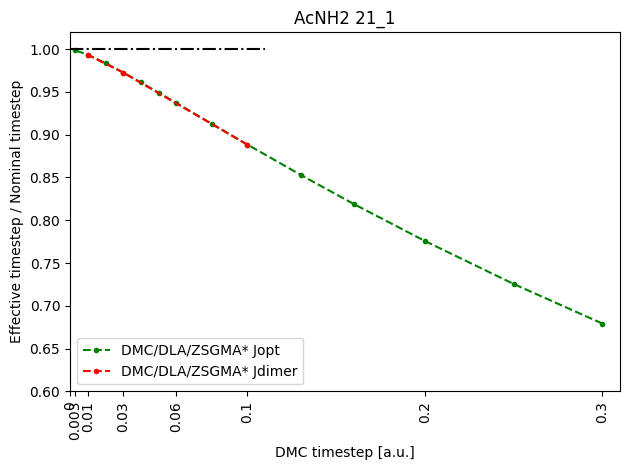

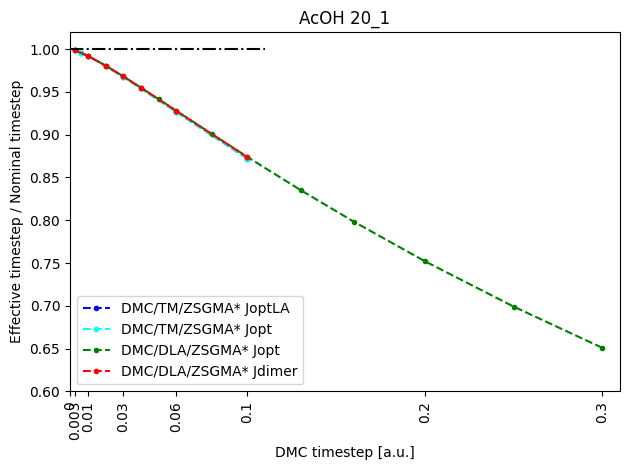

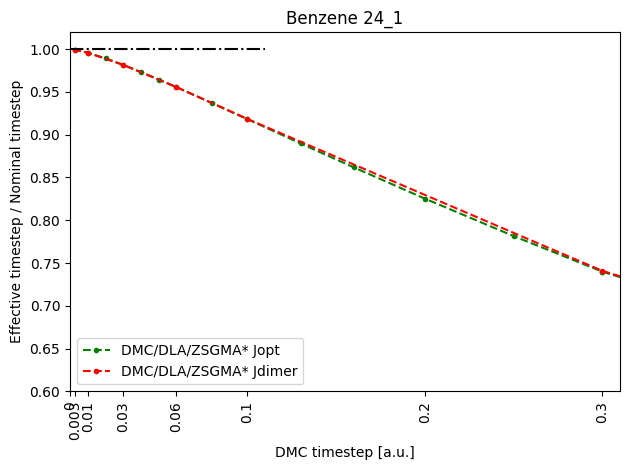

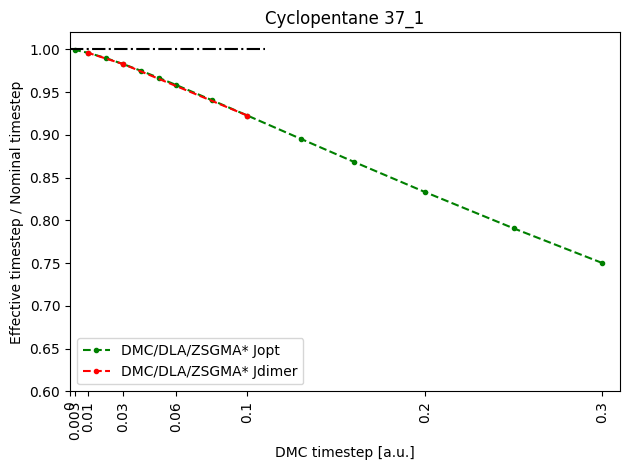

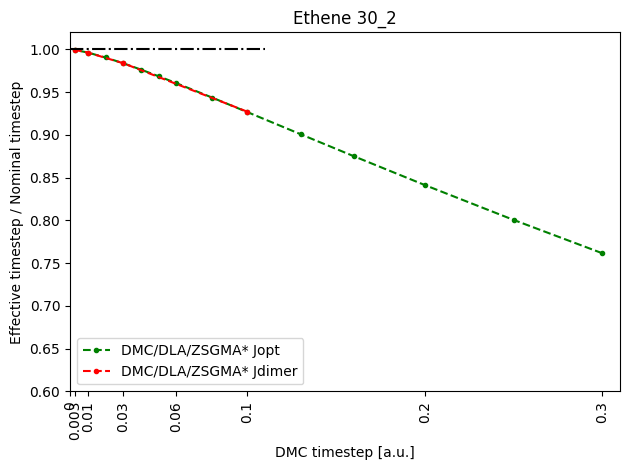

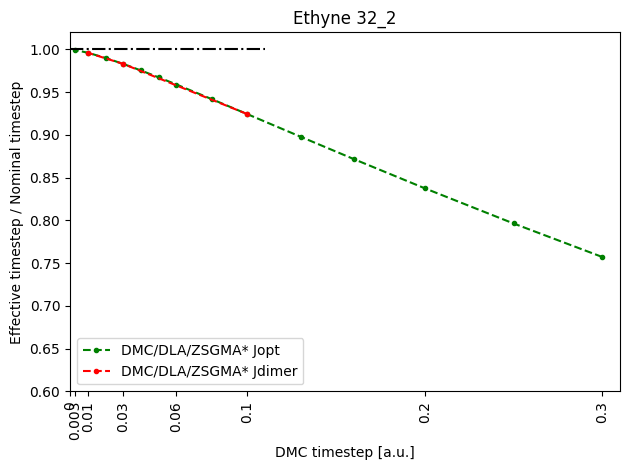

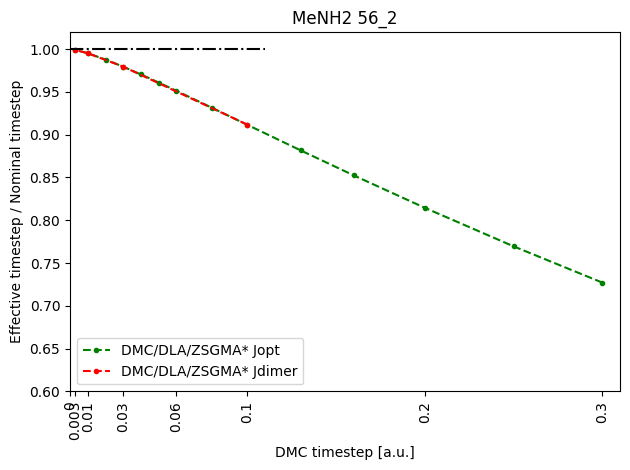

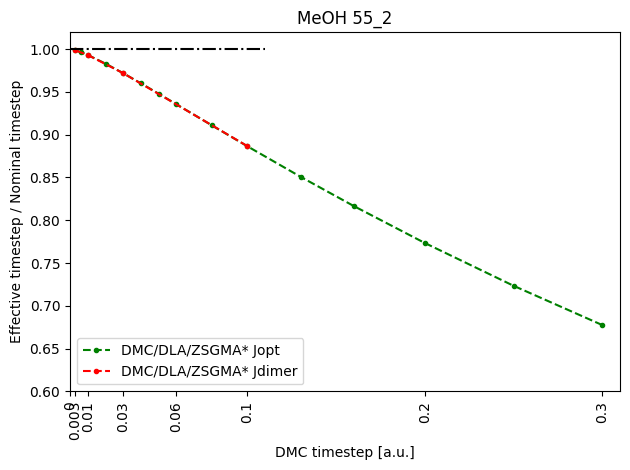

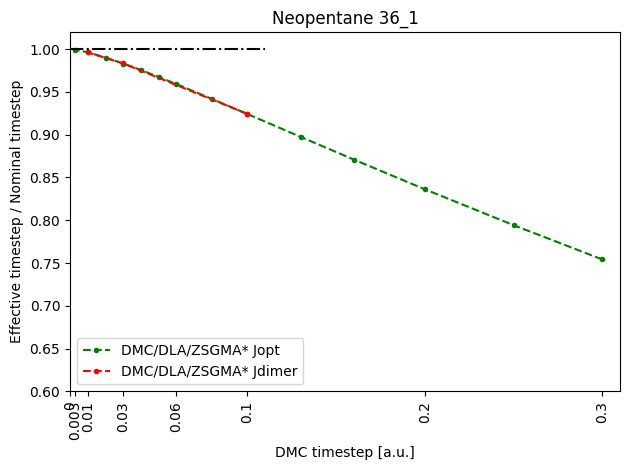

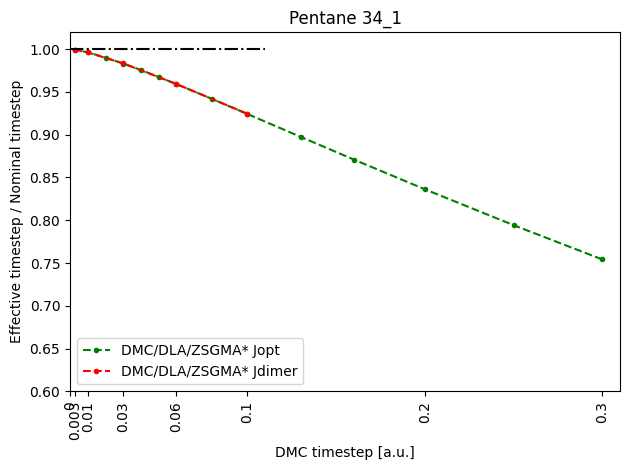

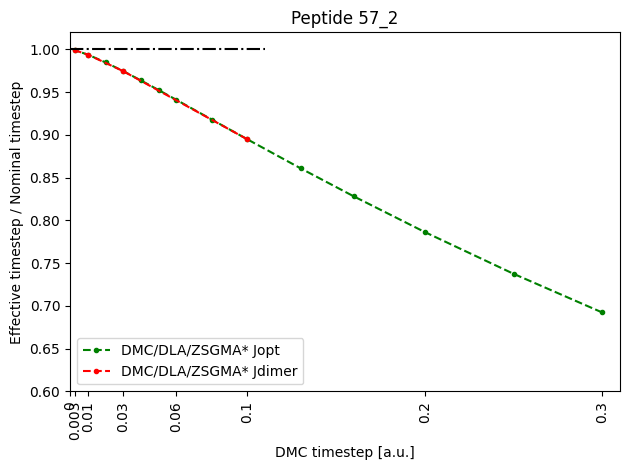

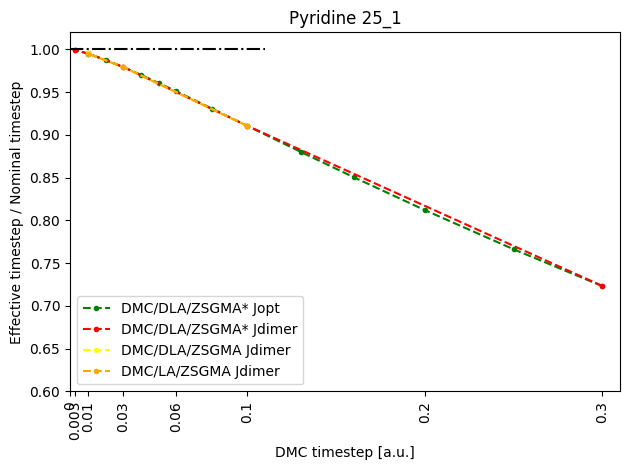

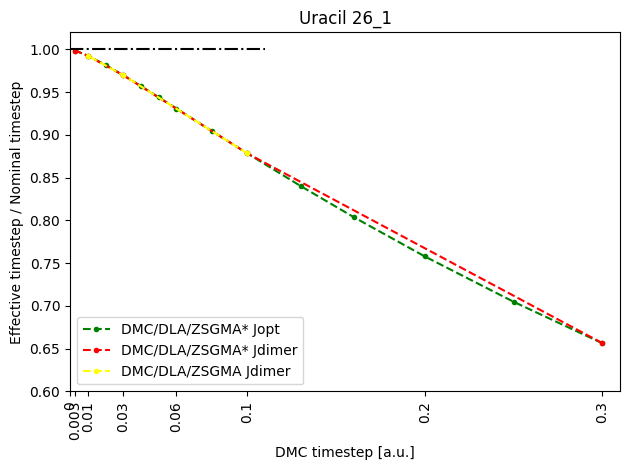

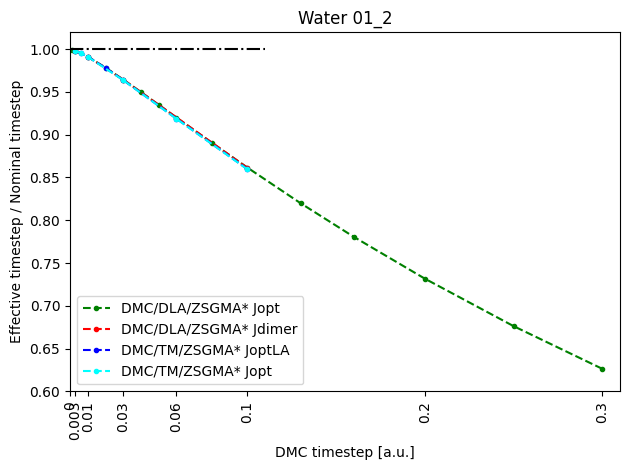

In [19]:
# Plot Effective timestep for representative molecules
verbose = False

xmax = 0.31
for idx, mol in enumerate( mol_names ):
    print(f'MOLECULE: {mol}')
    mol_id = mol_info[mol]['ref']
    print( f'Doing mol_id={mol_id}, idx={idx}' )

    fig, ax = plt.subplots() # figsize=(10, 15) )
    ax.set_title(f'{mol} {mol_id}')

    ax.set_xlim([0.,xmax])
    #ax.set_xticks(ticks=[0,0.003, 0.01, 0.03, 0.1, 0.2, 0.3])
    #ax.set_xticklabels(labels=['0','','0.01','0.03','0.1','0.2','0.3'],rotation=90)
    ticks=[0,0.003, 0.01, 0.03, 0.06, 0.1, 0.2, 0.3]
    ax.set_xticks(ticks=ticks)
    ax.set_xticklabels(labels=[str(i) for i in ticks],rotation=90)

    ax.set_ylabel('Effective timestep / Nominal timestep')
    ax.set_xlabel('DMC timestep [a.u.]')

    Ymin=1e6
    Ymax=-1e6
    for dmc_type in results_mol[mol][mol_id].keys():
        for dmc_Jas in results_mol[mol][mol_id][dmc_type].keys():
            data = results_mol[mol][mol_id][dmc_type][dmc_Jas]
            taus = data.keys()

            if verbose: 
                print( f'\n{mol} {mol_id} {dmc_type} {dmc_Jas} {len(taus)} tau {taus}' )

            df = pd.DataFrame( data ).transpose()
            df.index = [float(tau) for tau in df.index]
            df.sort_index(ascending=False, inplace=True)
            #df.astype({'ene':'float'}).dtypes

            if verbose: 
                print( df[['ene','err']] )

            try:
                taus = np.array( df.index, dtype=np.double )
                enes = np.array( df['ene'], dtype=np.double )
                errs = np.array( df['err'], dtype=np.double )
                Yname = 'tau_eff[au]'
                Y = np.array( df[Yname], dtype=np.double )
                Y = Y/taus
                #Yerr = np.array( df['Pop-err'], dtype=np.double )
                c = dmc_color( dmc_type, dmc_Jas )
                ax.plot( taus, Y, '.--', label=f'{map_DMC(dmc_type)} {dmc_Jas}', color=c )
                #ax.errorbar( taus, Y, Yerr, color=c, fmt='.' )
            except:
                pass
            thismin = min(np.array( df[ df.index<0.31 ][Yname], dtype=np.double ))
            thismax = max(np.array( df[ df.index<0.31 ][Yname], dtype=np.double ))
            if Ymin > thismin: 
                Ymin = thismin
                if verbose: print(f'\n*** min={Ymin}\tmax={Ymax} // update min ***')
            if Ymax < thismax:
                Ymax = thismax
                if verbose: print(f'\n*** min={Ymin}\tmax={Ymax} // update max ***')

    ax.hlines(1,0,0.11,color='black', linestyles='dashdot')#, label='Target')
    print(f'\n\nmin={Ymin}\tmax={Ymax}')
    #plt.ylim([0.86,1.02])  # for tau < 0.11
    plt.ylim([0.6,1.02])
    #ax.set_yticklabels(['{:,.0f}'.format(x) for x in ax.get_yticks()])

    ax.legend(loc=3)#loc='center left', bbox_to_anchor=(10.7, 0.5))

    fig.tight_layout()
    fig.savefig(f'FIG02a/EffTau_{mol}.png',format='png',dpi=300)